# Purpose of this notebook = leverage knowledge about neighbors' formation thicknesses

## What a geologist would do: 
#### Look at neighboring wells to find thickness of unit from a top and base pick, in prediction well flatten on base pick, and see where neighboring top pick lands on well in question. Further evaluation starts there. 
## Feature creation summary:
#### Find thickness of unit in neighboring wells in training dataset. Subtract that thickness from the base pick depth in the well we're going to predict for to find where that top pick would be in the prediction well if the thickness is the same.


## Feature Creation Additional Details:
- We could get quite elaborate with this in terms of whether neighbors are on all sides of prediction well or just one side or which neighbors are most similar in terms of total depth drilled, variances in gamma-ray, etc. 
- For now, we're going going to create two features (1) a prediction feature based on nearest neighbor thickness (2) a prediction feature based on average of nearest 5 neighbors. 
- Neighbor thickness helper features columns will be floats representing the distance from the depth predicted from neighbor thickness and prediction well base pick.
- We will also have column to keep track of the range between the smallest and largest neighbor thickness of that well. 
- This feature creation requires the things below, if they aren't present this shouldn't be used:
    - We have lat/long to determine neighbors.
    - We have a base pick and a top pick for each well.
    - We have reason to believe the thickness of neighbors is a good indicator or where the top will be in this well. Reasons that wouldn't be the case include: presence of faults, known local outliers, and possibly other things I haven't thought of yet. 

In [1]:
# Notebook to find: 
## 1. Check that we have created a subset of wells to use that have both tops and bases for a given unit.
## 2. A number of nearest neighbors of each well
## 3. Thickness of one or more zones for each nearest neighbor in set of n nearest neighbors
## 4. Where in the well a top would be predicted just based on base of unit and thickness of neighbors
### 4. b. Thickness of closest neighbor with both a top and a base
### 4.c Average thickness of nearest N neighbors
### 5. NOTE: We'll want to only use neighbors from the train data samples for the train rows and use both train and test neighbors for test rows. For this, we'll want to already have test and train classes assigned!

### Earlier notebooks were to explore lat/long position of wells & find nearest neighbors and functions to make a dataset of nearest neighbors within certain limits for each well and potentially functions to make a dataset of tops and other characteristics for neighboring wells.
### 

## Import modules and set display options

In [92]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import os
import folium
print("folium",folium.__version__)
import branca.colormap as cm
import os
import math
print("welly",welly.__version__)
import re

folium 0.5.0
welly 0.3.5


In [4]:
%%timeit
import os
env = %env

81 µs ± 8.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
pd.set_option('display.max_rows', 2000)

## Load pick, pick dictionary, well information, and well location via csv and text file


In [6]:
picks_dic = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('../../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
gis = pd.read_csv('../../../well_lat_lng.csv')

## Dataframe of well curves data created in load notebook

In [52]:
loaded_wells_dir = '../loadLAS/'
loaded_wells_df = 'df_all_wells_noKNNorFeatures_20180920_a.h5'

## Give top pick code that we want to predict
## and give base pick code that we want to assume we have 

In [15]:
####old verbage
# picks_new=picks[picks['HorID']==13000]
# picks_paleoz=picks[picks['HorID']==14000]

#### top pick code we are going to predict
picks_targetTop=picks[picks['HorID']==13000]
#### base pick code we are going to assume we have
picks_targetBase=picks[picks['HorID']==14000]

#### Note: these need to be in this order as we'll assume the second one will be written as 'HorID_x' by pandas as two columns can't have the same name

## Merge information from the various files into a pandas dataframe

In [149]:


df_new = pd.merge(wells, picks_targetTop, on='SitID')
df_paleoz = pd.merge(wells, picks_targetBase, on='SitID')
df_gis = pd.merge(df_paleoz, gis, on='SitID')
df_new=pd.merge(df_gis, df_new, on='SitID')
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


In [150]:
df_new.tail()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
2188,126239,1014133011AA0,AA/11-30-101-13W4/0,14000,497,1,1014133011AA0,AA/11-30-101-13W4/0,13000,457,3,57.796978,-112.129423,1014133011AA0,AA/11-30-101-13W4/0,13000,457,3
2189,126240,1014140811AA0,AA/11-08-101-14W4/0,14000,505,2,1014140811AA0,AA/11-08-101-14W4/0,13000,481,2,57.753273,-112.266195,1014140811AA0,AA/11-08-101-14W4/0,13000,481,2
2190,126241,1014141414AA0,AA/14-14-101-14W4/0,14000,502.31,1,1014141414AA0,AA/14-14-101-14W4/0,13000,471.22,3,57.771518,-112.184135,1014141414AA0,AA/14-14-101-14W4/0,13000,471.22,3
2191,126243,1014142906AA0,AA/06-29-101-14W4/0,14000,538,1,1014142906AA0,AA/06-29-101-14W4/0,13000,517,2,57.793366,-112.266201,1014142906AA0,AA/06-29-101-14W4/0,13000,517,2
2192,126244,1014143506AA0,AA/06-35-101-14W4/0,14000,584,1,1014143506AA0,AA/06-35-101-14W4/0,13000,539.7,1,57.807817,-112.184139,1014143506AA0,AA/06-35-101-14W4/0,13000,539.7,1


In [151]:
# ## Possible Steps to Chain for some of the possible features
# 0. Save and access pickle of all the CSVs chained into single data frame
# 1. Return array of UWIs of K neighbor wells, place as list in data frame
# 2. Place nearest well UWI of each well into new column 
# 3. Place nearest well pick depths into new column
# 4. place average pick depths of the array of wells into new column
# 5. do same thing for nearest well and nearest K wells but for average Gr, DPHI, and Resitivity value if present.
# 6. Calculate nearest and average value for distance between pick in question and known pick.

## Now let's import the dataframe of wells that have the tops and curves we want and limit the GIS dataframe to only those wells!

In [152]:
wellsLoaded_df_fromh5 = pd.read_hdf(loaded_wells_dir+loaded_wells_df, 'df')

In [153]:
wellsLoaded_df_fromh5.tail()

,CALI,COND,DELT,DEPT,DPHI,DT,GR,ILD,ILM,NPHI,PHID,RHOB,SFL,SFLU,SN,SP,UWI
1016,NaN,NaN,NaN,589.00,0.141,NaN,21.793,12.235,NaN,0.293,NaN,NaN,NaN,NaN,NaN,NaN,00-02-05-074-04W5-0.LAS
1017,NaN,NaN,NaN,589.25,0.134,NaN,22.354,12.235,NaN,0.276,NaN,NaN,NaN,NaN,NaN,NaN,00-02-05-074-04W5-0.LAS
1018,NaN,NaN,NaN,589.50,0.131,NaN,22.343,12.236,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,00-02-05-074-04W5-0.LAS
1019,NaN,NaN,NaN,589.75,0.126,NaN,22.327,12.462,NaN,0.252,NaN,NaN,NaN,NaN,NaN,NaN,00-02-05-074-04W5-0.LAS
1020,NaN,NaN,NaN,590.00,0.123,NaN,22.311,12.692,NaN,0.245,NaN,NaN,NaN,NaN,NaN,NaN,00-02-05-074-04W5-0.LAS


## Let's limit the GIS and pick information dataframe to only the wells we're going to use and exclude any we're not going to use for not having the needed tops and curves.

We'll have to change the format of the UWU col slightly to do this

In [154]:
wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()

In [155]:
len(wellsLoaded_list)

1822

In [156]:
wellsLoaded_list[9:14]

array(['00-06-32-069-04W4-0.LAS', '00-11-09-079-15W4-0.LAS',
       '00-08-29-077-10W4-0.LAS', 'AA-15-14-101-13W4-0.LAS',
       '00-10-20-075-18W4-0.LAS'], dtype=object)

In [157]:
def replacenthSubStr(string, sub, wanted, n):
    where = [m.start() for m in re.finditer(sub, string)][n-1]
    before = string[:where]
    after = string[where:]
    after = after.replace(sub, wanted, 1)
    newString = before + after
    return newString

In [158]:
def changeLASfileToBeUWIstr(lasStr):
    string1 = replacenthSubStr(lasStr,'-', '/', 5)
    string2 = replacenthSubStr(string1,'-', '/', 1).replace(".LAS","")
    return string2

In [159]:
def findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5):
    wellsLoaded_list = wellsLoaded_df_fromh5[['UWI']]['UWI'].unique()
    new_wells_loaded_list_inUWIstyle = []
    for lasStr in wellsLoaded_list:
        new_wells_loaded_list_inUWIstyle.append(changeLASfileToBeUWIstr(lasStr))
    return new_wells_loaded_list_inUWIstyle

In [160]:
new_wells_loaded_list_inUWIstyle = findListOfConvertedUWInamesForWellsLoaded(wellsLoaded_df_fromh5)

In [161]:
new_wells_loaded_list_inUWIstyle[5:8]

['00/10-08-067-17W4/0', '00/15-20-072-21W4/0', '00/11-04-092-18W4/0']

In [162]:
df_new_allWells = df_new.copy()
len(df_new_allWells)

2193

### This next step will reduce the total number of wells to just the ones that have at least the tops and curves we need

In [163]:
df_new = df_new[df_new['UWI'].isin(new_wells_loaded_list_inUWIstyle)]

Now that we've reduced the wells, we'll reset the index. We'll do this because another step below will use a loop that gets confused if there are index values missing. 

In [165]:
df_new = df_new.reset_index(drop=True)

In [166]:
df_new

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2
5,102503,0674030411000,00/11-04-067-03W4/0,14000,553.5,1,0674030411000,00/11-04-067-03W4/0,13000,488.5,2,54.771449,-110.402983,0674030411000,00/11-04-067-03W4/0,13000,488.5,2
6,102505,0674030810000,00/10-08-067-03W4/0,14000,572.5,1,0674030810000,00/10-08-067-03W4/0,13000,501.5,2,54.785901,-110.422131,0674030810000,00/10-08-067-03W4/0,13000,501.5,2
7,102507,0674031410000,00/10-14-067-03W4/0,14000,606.5,1,0674031410000,00/10-14-067-03W4/0,13000,553.5,2,54.800533,-110.345762,0674031410000,00/10-14-067-03W4/0,13000,553.5,2
8,102514,0674032810000,00/10-28-067-03W4/0,14000,558,1,0674032810000,00/10-28-067-03W4/0,13000,493.5,3,54.829633,-110.396621,0674032810000,00/10-28-067-03W4/0,13000,493.5,3
9,102517,0674033607000,00/07-36-067-03W4/0,14000,615,1,0674033607000,00/07-36-067-03W4/0,13000,536.5,2,54.840441,-110.320301,0674033607000,00/07-36-067-03W4/0,13000,536.5,2


## We'll now find nearest N neighbors using a kdtree approach

In [167]:
position = df_new[['lat','lng']]

In [168]:
tree = neighbors.KDTree(position, leaf_size=2) 

### Saving the tree of all the lat/lng points into pickle file named 'latlng_kd_tree_size2'

In [169]:
#### dumping tree to pickle file
pickle.dump( tree, open( "latlng_kd_tree_leaf3.p", "wb" ) )
!ls

MM_Top_Depth_Real_v_predBy_NN1thick_v2.html
latlng_kd_tree_leaf2b.p
latlng_kd_tree_leaf3.p
wellKNN_wKDtree-Post062018_vB.ipynb
wellKNN_wKDtree-Post092018_vC.ipynb
wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p
wells_df__NB_KDtreePost062018_vA__v1.p


### Let's make sure the kd_tree worked as indended by checking to see if two wells identified as being located near each other in fact have latitude and longitude that is close to each other.

In [170]:
dist, ind = tree.query([position][0], k=8)  

In [171]:
len(dist)

1822

In [172]:
len(ind)

1822

In [173]:
ind[4:5]

array([[ 4,  3, 63, 62,  2,  1, 64, 65]])

In [174]:
df_new[63:64]

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
63,103700,0684021109000,00/09-11-068-02W4/0,14000,603,1,0684021109000,00/09-11-068-02W4/0,13000,514,2,54.873176,-110.186834,0684021109000,00/09-11-068-02W4/0,13000,514,2


In [175]:
df_new[4:5]

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


### Okay, it appears KD tree has found neigbhors that are in fact near to each other

### Loading pickled tree file that was created above:

In [176]:
#### Load the previously dumped (saved) pickle file
#latlng_kd_tree_leaf2 = pickle.load(open( "latlng_kd_tree_size2b.p", "rb" ) )
latlng_kd_tree_leaf2 = pd.read_pickle("latlng_kd_tree_leaf3.p")
# latlng_kd_tree_leaf2b.p

In [177]:
#### Finding 8 nearest neighbors based on lat/long
#### K is number of neighbors
dist, ind = latlng_kd_tree_leaf2.query([position][0], k=8)  

In [178]:
#### Testing that ind for index array and dist for array of distances between point and neighbors works after pickling
print(ind,dist)

[[   0    2   61 ...    1   64    3]
 [   1    3    4 ...    2   62   67]
 [   2    0    4 ...    3   61   62]
 ...
 [1819 1820 1812 ... 1818 1808 1803]
 [1820 1819 1821 ... 1805 1815 1808]
 [1821 1818 1820 ... 1812 1817 1810]] [[0.         0.057531   0.0874943  ... 0.14017283 0.14539497 0.14676425]
 [0.         0.04734001 0.07332214 ... 0.08267377 0.09089701 0.11681159]
 [0.         0.057531   0.06649379 ... 0.09343692 0.10808167 0.12013968]
 ...
 [0.         0.040093   0.04404393 ... 0.14358519 0.15437856 0.15533278]
 [0.         0.040093   0.08332469 ... 0.17815722 0.18808135 0.18953798]
 [0.         0.05577925 0.08332469 ... 0.12364274 0.13721611 0.17046897]]


## Next step - in 6 parts

A. add an object of neighbors in order of distance as new column

B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

C. Find closest neighbor with base McMurray Pick, make new column with that pick depth

D. Find depth between top and base (B and C), make new column with that depth

E. Depth in D minus base McMurray in each well is nearest neighbor constant thickness prediction of top McMurray prediction

###### F. Do the same thing as B,C,D,E but for min, average, max of remaining neighbors of K wells

--------------------------

#### A. Add an object of neighbors in order of distance as new column

In [180]:
ind[0]

array([ 0,  2, 61, 63,  4,  1, 64,  3])

## This will add a new column to the dataframe that has an object that contains
### 1. {'neighbor': integer, 'UWI': 'string', 'distance': float}
### for N number of neighbors

In [187]:
def makeKNearNeighObj(df_new,pickleFileOfKDtree,numberNeighbors):
    #### Takes in 
    #### Returns 
    
    ##### first part......
    #### make a data frame of UWI & index from main dataframe
    UWIs = df_new[['UWI']]
    position = df_new[['lat','lng']]
    #UWIs.join(position, how='outer') 
    UWIs_Geog = pd.concat([UWIs, position], axis=1)
    #print(UWIs_Geog.head())
    #### Add object of tree for 8 neighbors to a dataframe
    latlng_kd_tree_leaf2 = pd.read_pickle(pickleFileOfKDtree)
    #### Finding 8 nearest neighbors based on lat/long
    #### K is number of neighbors
    dist, ind = latlng_kd_tree_leaf2.query([position][0], k=numberNeighbors) 
    neighbor_array_per_well_row = []
    #### for i in ind.length
    for i in range(len(ind)):
        #### get the array of index values of neighbors, note: first one is the point in question which should be ignored!
        neighbors_ind = ind[i][1:]
        # for each index in that array, 
        counter = 1
        array_of_holder_obj = []
        for n in neighbors_ind:
            #### start temp object of {"neighbor":"int","UWI":"string","distance":"float"}
            holder_obj = {"neighbor":"int","UWI":"string","distance":"float"}
            #### get the distance into the temp object using index of i and each,
            holder_obj['distance'] = dist[i][counter]
            #### get the UWI using i and the dataframe
            holder_obj['UWI'] = UWIs_Geog.loc[n,'UWI']
            #### and position via "counter"
            holder_obj['neighbor'] = counter
            #### add the temp object populated as a column entry into an array
            counter = counter + 1
            array_of_holder_obj.append(holder_obj)
        #### turn array of objects into series and add as new column to dataframe
        neighbor_array_per_well_row.append(array_of_holder_obj)
    UWIs_Geog['Neighbors_Obj'] = pd.Series(neighbor_array_per_well_row,index=UWIs.index)
    return UWIs_Geog

In [188]:
UWIs_Geog = makeKNearNeighObj(df_new,"latlng_kd_tree_leaf3.p",8)
UWIs_Geog.head()

,UWI,lat,lng,Neighbors_Obj
0,00/12-08-067-01W4/0,54.785907,-110.129320,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]"
1,00/07-08-067-02W4/0,54.782284,-110.269446,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]"
2,00/09-11-067-02W4/0,54.785892,-110.186851,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]"
3,00/10-29-067-02W4/0,54.829624,-110.269422,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]"
4,00/06-34-067-02W4/0,54.840471,-110.224832,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]"


In [189]:
#### Test results Part 1

#### Had to change display options to get this to print in full!
# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     pd.set_option('display.max_rows', 500)
#     pd.set_option('display.max_columns', 500)
#     pd.set_option('display.width', 1000)
#     pd.options.display.max_colwidth = 100000
#     print(UWIs_Geog[0:1]['Neighbors_Obj'])

## Now to clean the df_new dataframe, rename columns, and merge with the new dataframe that has the neighbors!

In [190]:
df_new.head()

,SitID,UWI (AGS)_x,UWI_x,HorID_x,Pick_x,Quality_x,UWI (AGS)_y,UWI_y,HorID_y,Pick_y,Quality_y,lat,lng,UWI (AGS),UWI,HorID,Pick,Quality
0,102496,0674010812000,00/12-08-067-01W4/0,14000,561,1,0674010812000,00/12-08-067-01W4/0,13000,475,3,54.785907,-110.129320,0674010812000,00/12-08-067-01W4/0,13000,475,3
1,102497,0674020807000,00/07-08-067-02W4/0,14000,604.5,1,0674020807000,00/07-08-067-02W4/0,13000,515,3,54.782284,-110.269446,0674020807000,00/07-08-067-02W4/0,13000,515,3
2,102498,0674021109000,00/09-11-067-02W4/0,14000,564,1,0674021109000,00/09-11-067-02W4/0,13000,480,3,54.785892,-110.186851,0674021109000,00/09-11-067-02W4/0,13000,480,3
3,102500,0674022910000,00/10-29-067-02W4/0,14000,636.5,1,0674022910000,00/10-29-067-02W4/0,13000,549,3,54.829624,-110.269422,0674022910000,00/10-29-067-02W4/0,13000,549,3
4,102501,0674023406000,00/06-34-067-02W4/0,14000,613,1,0674023406000,00/06-34-067-02W4/0,13000,529,2,54.840471,-110.224832,0674023406000,00/06-34-067-02W4/0,13000,529,2


In [210]:
def cleanRenameDF(df,topTarget,thicknessHelperTop):
    #### Takes in 
    #### Returns
    #### HorID and Pick should be for the topTarget & HorID_x and Pick_x should be for helper top which is a base of the unit
    #### First step is to check the assumption above:
    if df['HorID'][0:1][0] != topTarget or df['HorID_x'][0:1][0] != thicknessHelperTop:
        return "THERE WAS A PROBLEM AND THE COLUMNS AND TOPS VALUES DONT MATCH IN cleanRenameDF"
    else:
        df_new_cleaned = df_new[['SitID','HorID_x','Pick_x','Quality_x','HorID','Pick','Quality','lat','lng','UWI']].copy()
        df_new_cleaned['TopHelper_HorID'] = df_new_cleaned['HorID_x']
        df_new_cleaned['TopTarget_HorID'] = df_new_cleaned['HorID']
        df_new_cleaned['TopHelper_DEPTH'] = df_new_cleaned['Pick_x']
        df_new_cleaned['TopTarget_DEPTH'] = df_new_cleaned['Pick']
        df_new_cleaned['TopHelper_HorID_Qual'] = df_new_cleaned['Quality_x']
        df_new_cleaned['TopTarget_Qual'] = df_new_cleaned['Quality']
        df_new_cleaned = df_new_cleaned[['SitID','lat','lng','UWI','TopHelper_HorID','TopTarget_HorID','TopHelper_DEPTH','TopTarget_DEPTH','TopHelper_HorID_Qual','TopTarget_Qual']]
    return df_new_cleaned

In [219]:
df_new_cleaned = cleanRenameDF(df_new,13000,14000)

In [220]:
type(df_new_cleaned)

pandas.core.frame.DataFrame

In [221]:
df_new_cleaned.head()

,SitID,lat,lng,UWI,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual
0,102496,54.785907,-110.129320,00/12-08-067-01W4/0,14000,13000,561,475,1,3
1,102497,54.782284,-110.269446,00/07-08-067-02W4/0,14000,13000,604.5,515,1,3
2,102498,54.785892,-110.186851,00/09-11-067-02W4/0,14000,13000,564,480,1,3
3,102500,54.829624,-110.269422,00/10-29-067-02W4/0,14000,13000,636.5,549,1,3
4,102501,54.840471,-110.224832,00/06-34-067-02W4/0,14000,13000,613,529,1,2


#### Merge df_new_cleaned data frame with UWIs_Geog data frame

In [222]:
def mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog):
    df_new_cleaned_plus_nn = pd.concat([df_new_cleaned, UWIs_Geog[['Neighbors_Obj']].copy()], axis=1)
    return df_new_cleaned_plus_nn
    

In [223]:
df_new_cleaned_plus_nn = mergeCleanedAndUWIGeog_dfs(df_new_cleaned,UWIs_Geog)

In [224]:
df_new_cleaned_plus_nn.head()

,SitID,lat,lng,UWI,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj
0,102496,54.785907,-110.129320,00/12-08-067-01W4/0,14000,13000,561,475,1,3,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]"
1,102497,54.782284,-110.269446,00/07-08-067-02W4/0,14000,13000,604.5,515,1,3,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]"
2,102498,54.785892,-110.186851,00/09-11-067-02W4/0,14000,13000,564,480,1,3,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]"
3,102500,54.829624,-110.269422,00/10-29-067-02W4/0,14000,13000,636.5,549,1,3,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]"
4,102501,54.840471,-110.224832,00/06-34-067-02W4/0,14000,13000,613,529,1,2,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]"


#### This is how to access the data on nearest neigbhors in the 'Neighbors_Obj' column

In [225]:
#### The object for the 1st neighbor of the 1 index well
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][1]

{'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}

In [242]:
#### The distance from the well in question for that row to the 1st neighbor 
df_new_cleaned_plus_nn.loc[1:1,'Neighbors_Obj'][1][3]['distance']

0.07846755926496476

In [227]:
df_new_cleaned_plus_nn.iloc[0,10][1]['UWI']

'00/11-08-068-01W4/0'

In [243]:
### col 3 is McMurray_Base_DEPTH
df_new_cleaned_plus_nn.iloc[0,6]

'561'

In [244]:
### col 4 is McMurray_Top_DEPTH
df_new_cleaned_plus_nn.iloc[0,7]

'475'

In [230]:
test = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/06-34-067-02W4/0')
print(type(test),test)

<class 'int'> 4


In [231]:
df_new_cleaned_plus_nn.loc[1:2,'Neighbors_Obj'][2]

[{'neighbor': 1,
  'UWI': '00/12-08-067-01W4/0',
  'distance': 0.05753100195547899},
 {'neighbor': 2,
  'UWI': '00/06-34-067-02W4/0',
  'distance': 0.06649378619088428},
 {'neighbor': 3,
  'UWI': '00/07-08-067-02W4/0',
  'distance': 0.08267376663125782},
 {'neighbor': 4,
  'UWI': '00/09-11-068-02W4/0',
  'distance': 0.08728400165551212},
 {'neighbor': 5,
  'UWI': '00/10-29-067-02W4/0',
  'distance': 0.09343691917544036},
 {'neighbor': 6,
  'UWI': '00/11-08-068-01W4/0',
  'distance': 0.10808166919974113},
 {'neighbor': 7,
  'UWI': '00/10-08-068-02W4/0',
  'distance': 0.12013967631468725}]

### B. Find closest neighbor with top McMurray Pick, make new column with that pick depth

In [247]:
index_of_neigh = df_new_cleaned_plus_nn.set_index('UWI').index.get_loc('00/09-11-067-02W4/0')
index_of_neigh

2

In [251]:
df_new_cleaned_plus_nn.iloc[0,10][2]['UWI']

'00/09-11-068-02W4/0'

In [252]:
df_new_cleaned_plus_nn['SitID'][1]

102497

In [253]:
#### Neighbors_Obj must be 10th Col!!

def broadcastFuncForFindNearestNPickDepth(df,pickColInt,newPickColName):
    #### For each row in dataframe,
    df[newPickColName] = np.nan
    print( df.iloc[0:1][newPickColName])
    for eachRow in range(len(df)):
        #### Find the nearest neighbor UWI
        print(eachRow)
        UWI = df.iloc[eachRow,10][1]['UWI']
        print(type(UWI),"type to right of ",UWI)
        #### With the UWI from above, find the pickDepthName
        index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
        print("index_of_neigh_UWI= ",index_of_neigh_UWI)
        pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
        print("pick_depth ",pick_depth)
        try:
            pick_depth = float(pick_depth)
        except:
            UWI = df.iloc[eachRow,10][2]['UWI']
            index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
            pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
            try:
                pick_depth = float(pick_depth)
            except:
                UWI = df.iloc[eachRow,10][3]['UWI']
                index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                try:
                    pick_depth = float(pick_depth)
                except:
                    UWI = df.iloc[eachRow,10][4]['UWI']
                    index_of_neigh_UWI = df.set_index('UWI').index.get_loc(UWI)
                    pick_depth = df.iloc[index_of_neigh_UWI,pickColInt]
                    try:
                        pick_depth = float(pick_depth)
                    except:
                        pick_depth = "no_pick"
            
        #### Write the pickDepthName to a new column
#         df[newPickColName][eachRow] = pick_depth
        eachRowP1 = eachRow+1
        df.iloc[eachRow:eachRowP1][newPickColName] = pick_depth
    return df

In [257]:
temp2 = broadcastFuncForFindNearestNPickDepth(df_new_cleaned_plus_nn,7,'NN1_topTarget_DEPTH')

0   NaN
Name: NN1_topTarget_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  61
pick_depth  544
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  529
3
<class 'str'> type to right of  00/06-34-067-02W4/0


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


index_of_neigh_UWI=  4
pick_depth  529
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  63
pick_depth  514
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  493.5
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  553.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  501.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  509
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  70
pick_depth  511
13
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  70
pick_depth  511
14
<class '

index_of_neigh_UWI=  140
pick_depth  630
92
<class 'str'> type to right of  00/06-27-067-10W4/0
index_of_neigh_UWI=  30
pick_depth  518
93
<class 'str'> type to right of  00/10-12-069-10W4/0
index_of_neigh_UWI=  144
pick_depth  641.3
94
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  455
95
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  33
pick_depth  509
96
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  455
97
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  455
98
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  455
99
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  101
pick_depth  470
100
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  101
pick_depth  470
101
<class 'str'> type to right of  00/07-07-069-12W4/0
index_of_neigh_UWI=  152
pick_depth  460
1

179
<class 'str'> type to right of  00/11-30-070-04W4/0
index_of_neigh_UWI=  176
pick_depth  460
180
<class 'str'> type to right of  00/09-35-070-06W4/0
index_of_neigh_UWI=  185
pick_depth  473.5
181
<class 'str'> type to right of  00/05-19-070-05W4/0
index_of_neigh_UWI=  180
pick_depth  468
182
<class 'str'> type to right of  00/06-36-069-06W4/0
index_of_neigh_UWI=  134
pick_depth  504
183
<class 'str'> type to right of  00/10-33-070-06W4/0
index_of_neigh_UWI=  184
pick_depth  440
184
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  280
pick_depth  452.5
185
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  279
pick_depth  468
186
<class 'str'> type to right of  00/12-30-069-07W4/0
index_of_neigh_UWI=  136
pick_depth  470
187
<class 'str'> type to right of  00/06-30-069-09W4/0
index_of_neigh_UWI=  143
pick_depth  585
188
<class 'str'> type to right of  00/11-05-070-09W4/0
index_of_neigh_UWI=  187
pick_depth  492.5
189
<class 'str'> type t

index_of_neigh_UWI=  265
pick_depth  815.5
270
<class 'str'> type to right of  00/06-08-074-01W4/0
index_of_neigh_UWI=  562
pick_depth  517
271
<class 'str'> type to right of  00/12-36-072-03W4/0
index_of_neigh_UWI=  373
pick_depth  497
272
<class 'str'> type to right of  00/10-14-071-05W4/0
index_of_neigh_UWI=  276
pick_depth  446
273
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  275
pick_depth  461.5
274
<class 'str'> type to right of  00/15-32-071-04W4/0
index_of_neigh_UWI=  275
pick_depth  461.5
275
<class 'str'> type to right of  00/12-21-071-04W4/0
index_of_neigh_UWI=  274
pick_depth  455
276
<class 'str'> type to right of  00/10-25-071-05W4/0
index_of_neigh_UWI=  278
pick_depth  456.5
277
<class 'str'> type to right of  00/11-06-072-05W4/0
index_of_neigh_UWI=  379
pick_depth  459
278
<class 'str'> type to right of  00/12-18-071-04W4/0
index_of_neigh_UWI=  272
pick_depth  450
279
<class 'str'> type to right of  00/09-35-070-06W4/0
index_of_neigh_UWI=  1

353
<class 'str'> type to right of  00/11-16-071-26W4/0
index_of_neigh_UWI=  354
pick_depth  619
354
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  353
pick_depth  639.78
355
<class 'str'> type to right of  00/06-26-071-01W5/0
index_of_neigh_UWI=  358
pick_depth  624.5
356
<class 'str'> type to right of  00/11-32-070-01W5/0
index_of_neigh_UWI=  257
pick_depth  622.5
357
<class 'str'> type to right of  00/15-36-070-02W5/0
index_of_neigh_UWI=  261
pick_depth  614
358
<class 'str'> type to right of  00/07-19-071-26W4/0
index_of_neigh_UWI=  355
pick_depth  658.98
359
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  357
pick_depth  612
360
<class 'str'> type to right of  00/05-07-071-01W5/0
index_of_neigh_UWI=  357
pick_depth  612
361
<class 'str'> type to right of  00/06-22-071-02W5/0
index_of_neigh_UWI=  362
pick_depth  612.65
362
<class 'str'> type to right of  00/06-02-072-02W5/0
index_of_neigh_UWI=  457
pick_depth  603.5
363
<class 'str

index_of_neigh_UWI=  331
pick_depth  501.4
437
<class 'str'> type to right of  00/06-02-072-20W4/0
index_of_neigh_UWI=  435
pick_depth  492.25
438
<class 'str'> type to right of  00/11-12-072-20W4/0
index_of_neigh_UWI=  437
pick_depth  498.04
439
<class 'str'> type to right of  02/07-26-071-21W4/0
index_of_neigh_UWI=  334
pick_depth          
440
<class 'str'> type to right of  00/15-09-073-21W4/0
index_of_neigh_UWI=  534
pick_depth  550
441
<class 'str'> type to right of  00/11-01-073-21W4/0
index_of_neigh_UWI=  533
pick_depth  551.5
442
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  342
pick_depth  621.79
443
<class 'str'> type to right of  00/07-24-071-23W4/0
index_of_neigh_UWI=  342
pick_depth  621.79
444
<class 'str'> type to right of  00/10-33-071-23W4/0
index_of_neigh_UWI=  343
pick_depth  633.98
445
<class 'str'> type to right of  00/05-02-073-23W4/0
index_of_neigh_UWI=  537
pick_depth  573
446
<class 'str'> type to right of  00/16-20-072-23W4/0
index_

520
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  514
pick_depth  422.76
521
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  514
pick_depth  422.76
522
<class 'str'> type to right of  00/09-17-073-18W4/0
index_of_neigh_UWI=  523
pick_depth  467
523
<class 'str'> type to right of  00/10-22-073-18W4/0
index_of_neigh_UWI=  524
pick_depth  435.86
524
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  430
pick_depth  449.28
525
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  433
pick_depth  515
526
<class 'str'> type to right of  00/11-31-073-19W4/0
index_of_neigh_UWI=  528
pick_depth  546.2
527
<class 'str'> type to right of  00/02-01-073-19W4/0
index_of_neigh_UWI=  525
pick_depth          
528
<class 'str'> type to right of  00/11-21-073-19W4/0
index_of_neigh_UWI=  526
pick_depth  546.2
529
<class 'str'> type to right of  00/06-21-073-20W4/0
index_of_neigh_UWI=  531
pick_depth  591.92
530
<c

606
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  607
pick_depth  470.92
607
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  517
pick_depth  451.1
608
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  517
pick_depth  451.1
609
<class 'str'> type to right of  00/10-25-075-15W4/0
index_of_neigh_UWI=  697
pick_depth  555
610
<class 'str'> type to right of  00/06-32-074-16W4/0
index_of_neigh_UWI=  611
pick_depth          
611
<class 'str'> type to right of  00/06-08-075-16W4/0
index_of_neigh_UWI=  700
pick_depth  510.24
612
<class 'str'> type to right of  00/06-32-074-16W4/0
index_of_neigh_UWI=  611
pick_depth          
613
<class 'str'> type to right of  00/10-16-074-17W4/0
index_of_neigh_UWI=  614
pick_depth  418.19
614
<class 'str'> type to right of  00/06-23-074-17W4/0
index_of_neigh_UWI=  615
pick_depth  423.06
615
<class 'str'> type to right of  00/06-25-074-17W4/0
index_of_neigh_UWI=  616
pick_depth  446.84
6

index_of_neigh_UWI=  688
pick_depth  562
692
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  605
pick_depth  592.53
693
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  605
pick_depth  592.53
694
<class 'str'> type to right of  00/06-36-075-15W4/0
index_of_neigh_UWI=  699
pick_depth  541.32
695
<class 'str'> type to right of  00/06-05-076-14W4/0
index_of_neigh_UWI=  776
pick_depth  537.97
696
<class 'str'> type to right of  00/07-08-076-15W4/0
index_of_neigh_UWI=  782
pick_depth  555
697
<class 'str'> type to right of  00/06-30-075-14W4/0
index_of_neigh_UWI=  694
pick_depth  564.49
698
<class 'str'> type to right of  00/07-24-075-16W4/0
index_of_neigh_UWI=  702
pick_depth  546.81
699
<class 'str'> type to right of  00/06-30-075-14W4/0
index_of_neigh_UWI=  694
pick_depth  564.49
700
<class 'str'> type to right of  00/11-30-074-16W4/0
index_of_neigh_UWI=  610
pick_depth          
701
<class 'str'> type to right of  00/06-34-074-16W4/0
inde

777
<class 'str'> type to right of  00/02-27-076-14W4/0
index_of_neigh_UWI=  779
pick_depth  474.5
778
<class 'str'> type to right of  00/06-05-076-14W4/0
index_of_neigh_UWI=  776
pick_depth  537.97
779
<class 'str'> type to right of  00/11-10-076-14W4/0
index_of_neigh_UWI=  777
pick_depth  503
780
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  861
pick_depth  456
781
<class 'str'> type to right of  00/11-10-076-15W4/0
index_of_neigh_UWI=  783
pick_depth  531.27
782
<class 'str'> type to right of  00/07-30-075-15W4/0
index_of_neigh_UWI=  698
pick_depth  552
783
<class 'str'> type to right of  00/07-08-076-15W4/0
index_of_neigh_UWI=  782
pick_depth  555
784
<class 'str'> type to right of  00/11-10-076-15W4/0
index_of_neigh_UWI=  783
pick_depth  531.27
785
<class 'str'> type to right of  00/08-32-076-16W4/0
index_of_neigh_UWI=  787
pick_depth  500
786
<class 'str'> type to right of  00/07-22-076-16W4/0
index_of_neigh_UWI=  785
pick_depth  550.16
787
<class 'str'

860
<class 'str'> type to right of  00/07-16-077-14W4/0
index_of_neigh_UWI=  862
pick_depth  482
861
<class 'str'> type to right of  00/10-30-076-14W4/0
index_of_neigh_UWI=  780
pick_depth  491.95
862
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  861
pick_depth  456
863
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  861
pick_depth  456
864
<class 'str'> type to right of  00/04-26-077-15W4/0
index_of_neigh_UWI=  866
pick_depth  460
865
<class 'str'> type to right of  00/10-27-077-15W4/0
index_of_neigh_UWI=  867
pick_depth  474
866
<class 'str'> type to right of  00/07-22-077-15W4/0
index_of_neigh_UWI=  865
pick_depth  496
867
<class 'str'> type to right of  00/07-22-077-15W4/0
index_of_neigh_UWI=  865
pick_depth  496
868
<class 'str'> type to right of  00/11-26-077-16W4/0
index_of_neigh_UWI=  871
pick_depth  477
869
<class 'str'> type to right of  00/11-28-076-16W4/0
index_of_neigh_UWI=  786
pick_depth  519
870
<class 'str'> type to r

947
<class 'str'> type to right of  00/06-33-078-18W4/0
index_of_neigh_UWI=  948
pick_depth  362.1
948
<class 'str'> type to right of  00/10-14-078-18W4/0
index_of_neigh_UWI=  947
pick_depth  362.1
949
<class 'str'> type to right of  00/05-29-078-19W4/0
index_of_neigh_UWI=  950
pick_depth  374
950
<class 'str'> type to right of  00/06-26-078-19W4/0
index_of_neigh_UWI=  949
pick_depth  374
951
<class 'str'> type to right of  00/11-36-078-21W4/0
index_of_neigh_UWI=  953
pick_depth  388.32
952
<class 'str'> type to right of  00/06-16-079-21W4/0
index_of_neigh_UWI=  1035
pick_depth  399
953
<class 'str'> type to right of  00/10-33-078-21W4/0
index_of_neigh_UWI=  952
pick_depth  409
954
<class 'str'> type to right of  00/14-14-079-22W4/0
index_of_neigh_UWI=  1038
pick_depth  413
955
<class 'str'> type to right of  00/07-09-078-23W4/0
index_of_neigh_UWI=  956
pick_depth  497.5
956
<class 'str'> type to right of  00/10-23-078-23W4/0
index_of_neigh_UWI=  957
pick_depth  444.7
957
<class 'str'>

1033
<class 'str'> type to right of  00/10-13-080-19W4/0
index_of_neigh_UWI=  1109
pick_depth  358.44
1034
<class 'str'> type to right of  00/10-33-078-21W4/0
index_of_neigh_UWI=  952
pick_depth  409
1035
<class 'str'> type to right of  00/10-33-078-21W4/0
index_of_neigh_UWI=  952
pick_depth  409
1036
<class 'str'> type to right of  00/11-09-080-21W4/0
index_of_neigh_UWI=  1115
pick_depth  409.04
1037
<class 'str'> type to right of  00/05-12-079-21W4/0
index_of_neigh_UWI=  1034
pick_depth  396
1038
<class 'str'> type to right of  00/07-21-079-22W4/0
index_of_neigh_UWI=  1039
pick_depth  405.99
1039
<class 'str'> type to right of  00/14-14-079-22W4/0
index_of_neigh_UWI=  1038
pick_depth  413
1040
<class 'str'> type to right of  00/04-01-080-22W4/0
index_of_neigh_UWI=  1116
pick_depth  436
1041
<class 'str'> type to right of  AA/11-01-080-23W4/0
index_of_neigh_UWI=  1120
pick_depth  439.5
1042
<class 'str'> type to right of  00/10-34-078-23W4/0
index_of_neigh_UWI=  959
pick_depth  448.06

index_of_neigh_UWI=  1036
pick_depth  402
1116
<class 'str'> type to right of  00/14-14-079-22W4/0
index_of_neigh_UWI=  1038
pick_depth  413
1117
<class 'str'> type to right of  00/01-32-080-22W4/0
index_of_neigh_UWI=  1119
pick_depth  416
1118
<class 'str'> type to right of  00/06-15-080-22W4/0
index_of_neigh_UWI=  1117
pick_depth  416
1119
<class 'str'> type to right of  00/06-15-080-22W4/0
index_of_neigh_UWI=  1117
pick_depth  416
1120
<class 'str'> type to right of  00/01-27-079-23W4/0
index_of_neigh_UWI=  1043
pick_depth  441
1121
<class 'str'> type to right of  AA/11-01-080-23W4/0
index_of_neigh_UWI=  1120
pick_depth  439.5
1122
<class 'str'> type to right of  00/10-15-080-23W4/0
index_of_neigh_UWI=  1121
pick_depth  447
1123
<class 'str'> type to right of  00/06-01-080-24W4/0
index_of_neigh_UWI=  1124
pick_depth  429
1124
<class 'str'> type to right of  00/11-26-080-24W4/0
index_of_neigh_UWI=  1126
pick_depth  433.5
1125
<class 'str'> type to right of  00/06-01-080-24W4/0
index_

1199
<class 'str'> type to right of  00/10-26-081-25W4/0
index_of_neigh_UWI=  1202
pick_depth  429.77
1200
<class 'str'> type to right of  00/10-07-081-24W4/0
index_of_neigh_UWI=  1195
pick_depth  446.23
1201
<class 'str'> type to right of  00/10-26-081-25W4/0
index_of_neigh_UWI=  1202
pick_depth  429.77
1202
<class 'str'> type to right of  00/07-11-082-25W4/0
index_of_neigh_UWI=  1275
pick_depth  426.72
1203
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1205
pick_depth  455.98
1204
<class 'str'> type to right of  00/07-26-080-02W5/0
index_of_neigh_UWI=  1131
pick_depth  487
1205
<class 'str'> type to right of  00/15-19-081-01W5/0
index_of_neigh_UWI=  1203
pick_depth  440.44
1206
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1205
pick_depth  455.98
1207
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1205
pick_depth  455.98
1208
<class 'str'> type to right of  00/11-31-078-05W5/0
index_of_neigh_UWI=  976
pic

1288
<class 'str'> type to right of  00/10-33-082-06W4/0
index_of_neigh_UWI=  1220
pick_depth  232
1289
<class 'str'> type to right of  00/06-05-084-06W4/0
index_of_neigh_UWI=  1353
pick_depth  301
1290
<class 'str'> type to right of  00/10-23-083-07W4/0
index_of_neigh_UWI=  1294
pick_depth  330.5
1291
<class 'str'> type to right of  00/11-24-084-06W4/0
index_of_neigh_UWI=  1354
pick_depth  190
1292
<class 'str'> type to right of  00/10-23-083-07W4/0
index_of_neigh_UWI=  1294
pick_depth  330.5
1293
<class 'str'> type to right of  00/07-33-083-07W4/0
index_of_neigh_UWI=  1295
pick_depth  334
1294
<class 'str'> type to right of  00/16-03-083-07W4/0
index_of_neigh_UWI=  1292
pick_depth  395
1295
<class 'str'> type to right of  AA/11-15-084-07W4/0
index_of_neigh_UWI=  1357
pick_depth  333
1296
<class 'str'> type to right of  00/06-25-082-09W4/0
index_of_neigh_UWI=  1230
pick_depth  453.54
1297
<class 'str'> type to right of  AA/10-23-082-08W4/0
index_of_neigh_UWI=  1226
pick_depth  454
129

index_of_neigh_UWI=  1369
pick_depth  274
1372
<class 'str'> type to right of  00/04-26-084-15W4/0
index_of_neigh_UWI=  1376
pick_depth          
1373
<class 'str'> type to right of  00/04-26-084-15W4/0
index_of_neigh_UWI=  1376
pick_depth          
1374
<class 'str'> type to right of  00/04-26-084-15W4/0
index_of_neigh_UWI=  1376
pick_depth          
1375
<class 'str'> type to right of  00/01-05-085-15W4/0
index_of_neigh_UWI=  1412
pick_depth  253
1376
<class 'str'> type to right of  00/04-30-084-14W4/0
index_of_neigh_UWI=  1372
pick_depth  256
1377
<class 'str'> type to right of  00/06-24-083-16W4/0
index_of_neigh_UWI=  1319
pick_depth  259.08
1378
<class 'str'> type to right of  00/07-34-083-16W4/0
index_of_neigh_UWI=  1320
pick_depth  261
1379
<class 'str'> type to right of  00/04-20-084-15W4/0
index_of_neigh_UWI=  1375
pick_depth  253
1380
<class 'str'> type to right of  00/06-24-084-16W4/0
index_of_neigh_UWI=  1379
pick_depth  257
1381
<class 'str'> type to right of  00/01-21-084

index_of_neigh_UWI=  1457
pick_depth          
1456
<class 'str'> type to right of  00/15-35-087-17W4/0
index_of_neigh_UWI=  1458
pick_depth          
1457
<class 'str'> type to right of  00/05-01-088-17W4/0
index_of_neigh_UWI=  1483
pick_depth          
1458
<class 'str'> type to right of  00/06-12-088-17W4/0
index_of_neigh_UWI=  1484
pick_depth  239
1459
<class 'str'> type to right of  00/13-23-086-18W4/0
index_of_neigh_UWI=  1436
pick_depth  229
1460
<class 'str'> type to right of  00/12-34-087-18W4/0
index_of_neigh_UWI=  1462
pick_depth          
1461
<class 'str'> type to right of  00/15-04-088-18W4/0
index_of_neigh_UWI=  1486
pick_depth  225
1462
<class 'str'> type to right of  00/07-22-088-18W4/0
index_of_neigh_UWI=  1488
pick_depth  205
1463
<class 'str'> type to right of  AA/10-05-088-19W4/0
index_of_neigh_UWI=  1490
pick_depth  255
1464
<class 'str'> type to right of  00/11-12-087-22W4/0
index_of_neigh_UWI=  1466
pick_depth  326
1465
<class 'str'> type to right of  00/11-32-0

1538
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1509
pick_depth  117.5
1539
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1509
pick_depth  117.5
1540
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1509
pick_depth  117.5
1541
<class 'str'> type to right of  AA/06-35-090-10W4/0
index_of_neigh_UWI=  1543
pick_depth  65
1542
<class 'str'> type to right of  AA/06-11-091-10W4/0
index_of_neigh_UWI=  1571
pick_depth  39
1543
<class 'str'> type to right of  AA/09-28-090-10W4/0
index_of_neigh_UWI=  1542
pick_depth  56
1544
<class 'str'> type to right of  00/11-29-089-12W4/0
index_of_neigh_UWI=  1513
pick_depth  214
1545
<class 'str'> type to right of  AA/10-08-089-14W4/0
index_of_neigh_UWI=  1515
pick_depth  202
1546
<class 'str'> type to right of  AA/07-11-090-15W4/0
index_of_neigh_UWI=  1547
pick_depth  185.5
1547
<class 'str'> type to right of  AA/09-08-090-15W4/0
index_of_neigh_UWI=  1546
pick_depth  183
1548


1626
<class 'str'> type to right of  00/04-24-092-20W4/0
index_of_neigh_UWI=  1624
pick_depth          
1627
<class 'str'> type to right of  00/10-14-092-21W4/0
index_of_neigh_UWI=  1629
pick_depth          
1628
<class 'str'> type to right of  00/10-18-092-20W4/0
index_of_neigh_UWI=  1623
pick_depth          
1629
<class 'str'> type to right of  00/06-13-092-21W4/0
index_of_neigh_UWI=  1628
pick_depth          
1630
<class 'str'> type to right of  00/06-13-092-21W4/0
index_of_neigh_UWI=  1628
pick_depth          
1631
<class 'str'> type to right of  00/12-23-092-21W4/0
index_of_neigh_UWI=  1630
pick_depth          
1632
<class 'str'> type to right of  AA/10-20-094-06W4/0
index_of_neigh_UWI=  1673
pick_depth  232
1633
<class 'str'> type to right of  AA/10-12-093-08W4/0
index_of_neigh_UWI=  1634
pick_depth  150
1634
<class 'str'> type to right of  AA/10-02-093-08W4/0
index_of_neigh_UWI=  1633
pick_depth  129.5
1635
<class 'str'> type to right of  AA/10-24-093-08W4/0
index_of_neigh_UWI= 

1708
<class 'str'> type to right of  00/10-03-094-21W4/0
index_of_neigh_UWI=  1706
pick_depth          
1709
<class 'str'> type to right of  00/07-06-095-21W4/0
index_of_neigh_UWI=  1727
pick_depth          
1710
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1675
pick_depth  272
1711
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1675
pick_depth  272
1712
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1674
pick_depth  252
1713
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  1712
pick_depth  221
1714
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  1730
pick_depth  98
1715
<class 'str'> type to right of  AB/10-18-096-10W4/0
index_of_neigh_UWI=  1738
pick_depth  13.5
1716
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_neigh_UWI=  1697
pick_depth  272
1717
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_neigh_UWI=  1697
pick_depth  272


1793
<class 'str'> type to right of  AA/07-24-098-12W4/0
index_of_neigh_UWI=  1796
pick_depth  73.46
1794
<class 'str'> type to right of  AA/15-19-098-12W4/0
index_of_neigh_UWI=  1795
pick_depth  437
1795
<class 'str'> type to right of  AA/04-08-098-12W4/0
index_of_neigh_UWI=  1794
pick_depth  237
1796
<class 'str'> type to right of  AA/15-01-098-12W4/0
index_of_neigh_UWI=  1793
pick_depth  66.5
1797
<class 'str'> type to right of  AA/02-06-099-12W4/0
index_of_neigh_UWI=  1799
pick_depth  545
1798
<class 'str'> type to right of  AA/02-06-099-12W4/0
index_of_neigh_UWI=  1799
pick_depth  545
1799
<class 'str'> type to right of  AA/07-29-099-12W4/0
index_of_neigh_UWI=  1800
pick_depth  364
1800
<class 'str'> type to right of  AA/09-23-099-13W4/0
index_of_neigh_UWI=  1801
pick_depth  569.5
1801
<class 'str'> type to right of  AA/11-13-100-13W4/0
index_of_neigh_UWI=  1811
pick_depth  530.5
1802
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  1805
pick_depth  530.5
1

In [258]:
temp2.describe()

,SitID,lat,lng,TopHelper_HorID,TopTarget_HorID,TopHelper_HorID_Qual,TopTarget_Qual,NN1_McMurray_Top_DEPTH,NN1_topTarget_DEPTH
count,1822.000000,1822.000000,1822.000000,1822.0,1822.0,1822.000000,1822.000000,1405.0,1749.000000
mean,118267.667398,55.868724,-112.196866,14000.0,13000.0,1.345225,1.575741,14000.0,403.759754
std,16906.677921,0.734204,1.122841,0.0,0.0,0.767923,0.944084,0.0,157.628505
min,102496.000000,54.764109,-114.774119,14000.0,13000.0,1.000000,0.000000,14000.0,1.500000
25%,108150.250000,55.280861,-113.025834,14000.0,13000.0,1.000000,1.000000,14000.0,298.700000
50%,112304.000000,55.744611,-112.129512,14000.0,13000.0,1.000000,1.000000,14000.0,440.000000
75%,120231.000000,56.284548,-111.273111,14000.0,13000.0,1.000000,2.000000,14000.0,493.000000
max,184130.000000,57.807827,-110.008902,14000.0,13000.0,4.000000,3.000000,14000.0,920.500000


In [261]:
temp2.head()

,SitID,lat,lng,UWI,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH
0,102496,54.785907,-110.129320,00/12-08-067-01W4/0,14000,13000,561,475,1,3,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.0
1,102497,54.782284,-110.269446,00/07-08-067-02W4/0,14000,13000,604.5,515,1,3,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.0
2,102498,54.785892,-110.186851,00/09-11-067-02W4/0,14000,13000,564,480,1,3,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.0
3,102500,54.829624,-110.269422,00/10-29-067-02W4/0,14000,13000,636.5,549,1,3,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.0
4,102501,54.840471,-110.224832,00/06-34-067-02W4/0,14000,13000,613,529,1,2,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.0


In [50]:
##temp3 = temp2[['SitID','McMurray_Base_HorID','McMurray_Top_HorID','McMurray_Base_DEPTH','McMurray_Top_DEPTH','McMurray_Base_Qual','McMurray_Top_Qual','lat','lng','UWI','Neighbors_Obj','NN1_McMurray_Top_DEPTH']]

In [266]:
##temp3.head()

In [262]:
df_new2 = broadcastFuncForFindNearestNPickDepth(temp2,6,'NN1_TopHelper_DEPTH')

0   NaN
Name: NN1_TopHelper_DEPTH, dtype: float64
0
<class 'str'> type to right of  00/11-08-068-01W4/0
index_of_neigh_UWI=  61
pick_depth  630
1
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
2
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3
<class 'str'> type to right of  00/06-34-067-02W4/0
index_of_neigh_UWI=  4
pick_depth  613
4
<class 'str'> type to right of  00/09-11-068-02W4/0
index_of_neigh_UWI=  63
pick_depth  603
5
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
6
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
7
<class 'str'> type to right of  00/10-28-067-03W4/0
index_of_neigh_UWI=  8
pick_depth  558
8
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
9
<class 'str'> type to right of  00/10-14-067-03W4/0
index_of_neigh_UWI=  7
pick_depth  606.5
10
<class 'str'> type to right of  00/10-08-067-03W4/0
index_of_neigh_UWI=  6
pick_depth  572.5
11
<class 'str'> type to right of  00/07-33-067-04W4/0
index_of_neigh_UWI=  13
pick_depth  570
12
<class 'str'> type to right of  00/11-02-068-04W4/0
index_of_neigh_UWI=  70
pick_depth  577
13
<class 'str'> type to right of  00/11-02-068-04W4/0
ind

91
<class 'str'> type to right of  00/07-06-069-09W4/0
index_of_neigh_UWI=  140
pick_depth  681.5
92
<class 'str'> type to right of  00/06-27-067-10W4/0
index_of_neigh_UWI=  30
pick_depth  567.5
93
<class 'str'> type to right of  00/10-12-069-10W4/0
index_of_neigh_UWI=  144
pick_depth  690.07
94
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  481
95
<class 'str'> type to right of  00/10-33-067-11W4/0
index_of_neigh_UWI=  33
pick_depth  545
96
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  481
97
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  481
98
<class 'str'> type to right of  00/13-09-068-11W4/0
index_of_neigh_UWI=  95
pick_depth  481
99
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  101
pick_depth  493.78
100
<class 'str'> type to right of  00/11-29-068-12W4/0
index_of_neigh_UWI=  101
pick_depth  493.78
101
<class 'str'> type to right 

index_of_neigh_UWI=  127
pick_depth  537
176
<class 'str'> type to right of  00/12-18-071-04W4/0
index_of_neigh_UWI=  272
pick_depth  510
177
<class 'str'> type to right of  00/05-21-071-04W4/0
index_of_neigh_UWI=  273
pick_depth  500
178
<class 'str'> type to right of  00/09-12-070-06W4/0
index_of_neigh_UWI=  182
pick_depth  556
179
<class 'str'> type to right of  00/11-30-070-04W4/0
index_of_neigh_UWI=  176
pick_depth  513.5
180
<class 'str'> type to right of  00/09-35-070-06W4/0
index_of_neigh_UWI=  185
pick_depth  556
181
<class 'str'> type to right of  00/05-19-070-05W4/0
index_of_neigh_UWI=  180
pick_depth  543
182
<class 'str'> type to right of  00/06-36-069-06W4/0
index_of_neigh_UWI=  134
pick_depth  583
183
<class 'str'> type to right of  00/10-33-070-06W4/0
index_of_neigh_UWI=  184
pick_depth  493
184
<class 'str'> type to right of  00/10-17-071-06W4/0
index_of_neigh_UWI=  280
pick_depth  507
185
<class 'str'> type to right of  00/09-14-071-06W4/0
index_of_neigh_UWI=  279
pic

index_of_neigh_UWI=  357
pick_depth  624
262
<class 'str'> type to right of  00/06-35-070-03W5/0
index_of_neigh_UWI=  264
pick_depth  675
263
<class 'str'> type to right of  00/12-20-071-03W5/0
index_of_neigh_UWI=  365
pick_depth  727
264
<class 'str'> type to right of  00/11-33-070-03W5/0
index_of_neigh_UWI=  263
pick_depth  697
265
<class 'str'> type to right of  00/07-15-071-04W5/0
index_of_neigh_UWI=  368
pick_depth  710.18
266
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  267
pick_depth  902
267
<class 'str'> type to right of  00/11-05-070-05W5/0
index_of_neigh_UWI=  266
pick_depth  957.07
268
<class 'str'> type to right of  00/11-10-070-05W5/0
index_of_neigh_UWI=  267
pick_depth  902
269
<class 'str'> type to right of  00/06-17-070-04W5/0
index_of_neigh_UWI=  265
pick_depth  836
270
<class 'str'> type to right of  00/06-08-074-01W4/0
index_of_neigh_UWI=  562
pick_depth  626.5
271
<class 'str'> type to right of  00/12-36-072-03W4/0
index_of_neigh_UWI=  3

index_of_neigh_UWI=  346
pick_depth  633.98
346
<class 'str'> type to right of  00/10-18-071-24W4/0
index_of_neigh_UWI=  344
pick_depth  643.74
347
<class 'str'> type to right of  00/11-21-071-24W4/0
index_of_neigh_UWI=  345
pick_depth  638.56
348
<class 'str'> type to right of  00/10-23-070-26W4/0
index_of_neigh_UWI=  250
pick_depth  665.99
349
<class 'str'> type to right of  00/06-21-071-25W4/0
index_of_neigh_UWI=  350
pick_depth  622.4
350
<class 'str'> type to right of  00/06-32-070-25W4/0
index_of_neigh_UWI=  247
pick_depth  687
351
<class 'str'> type to right of  00/10-31-071-24W4/0
index_of_neigh_UWI=  346
pick_depth  633.98
352
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  353
pick_depth  680.92
353
<class 'str'> type to right of  00/11-16-071-26W4/0
index_of_neigh_UWI=  354
pick_depth  659
354
<class 'str'> type to right of  00/10-15-071-26W4/0
index_of_neigh_UWI=  353
pick_depth  680.92
355
<class 'str'> type to right of  00/06-26-071-01W5/0
index_o

index_of_neigh_UWI=  522
pick_depth  493.17
431
<class 'str'> type to right of  00/12-30-071-19W4/0
index_of_neigh_UWI=  326
pick_depth  490.5
432
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  433
pick_depth  533
433
<class 'str'> type to right of  00/11-36-072-19W4/0
index_of_neigh_UWI=  434
pick_depth  551.69
434
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  433
pick_depth  533
435
<class 'str'> type to right of  00/11-34-071-20W4/0
index_of_neigh_UWI=  331
pick_depth  531.57
436
<class 'str'> type to right of  00/11-34-071-20W4/0
index_of_neigh_UWI=  331
pick_depth  531.57
437
<class 'str'> type to right of  00/06-02-072-20W4/0
index_of_neigh_UWI=  435
pick_depth  493.78
438
<class 'str'> type to right of  00/11-12-072-20W4/0
index_of_neigh_UWI=  437
pick_depth  502.92
439
<class 'str'> type to right of  02/07-26-071-21W4/0
index_of_neigh_UWI=  334
pick_depth  518
440
<class 'str'> type to right of  00/15-09-073-21W4/0
index_of_n

518
<class 'str'> type to right of  00/06-36-072-17W4/0
index_of_neigh_UWI=  426
pick_depth  458.42
519
<class 'str'> type to right of  00/10-16-074-17W4/0
index_of_neigh_UWI=  614
pick_depth  427.63
520
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  514
pick_depth  445.62
521
<class 'str'> type to right of  00/11-19-073-16W4/0
index_of_neigh_UWI=  514
pick_depth  445.62
522
<class 'str'> type to right of  00/09-17-073-18W4/0
index_of_neigh_UWI=  523
pick_depth  475
523
<class 'str'> type to right of  00/10-22-073-18W4/0
index_of_neigh_UWI=  524
pick_depth  437.39
524
<class 'str'> type to right of  00/06-34-072-18W4/0
index_of_neigh_UWI=  430
pick_depth  458.72
525
<class 'str'> type to right of  00/06-23-072-19W4/0
index_of_neigh_UWI=  433
pick_depth  533
526
<class 'str'> type to right of  00/11-31-073-19W4/0
index_of_neigh_UWI=  528
pick_depth  564.18
527
<class 'str'> type to right of  00/02-01-073-19W4/0
index_of_neigh_UWI=  525
pick_depth  498.5
528
<cl

602
<class 'str'> type to right of  00/11-30-073-13W4/0
index_of_neigh_UWI=  504
pick_depth  550
603
<class 'str'> type to right of  00/11-36-074-15W4/0
index_of_neigh_UWI=  609
pick_depth  603.5
604
<class 'str'> type to right of  00/10-01-074-14W4/0
index_of_neigh_UWI=  602
pick_depth  575
605
<class 'str'> type to right of  00/07-03-075-14W4/0
index_of_neigh_UWI=  692
pick_depth  630
606
<class 'str'> type to right of  00/10-06-074-15W4/0
index_of_neigh_UWI=  607
pick_depth  493.78
607
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  517
pick_depth  477.01
608
<class 'str'> type to right of  00/10-36-073-16W4/0
index_of_neigh_UWI=  517
pick_depth  477.01
609
<class 'str'> type to right of  00/10-25-075-15W4/0
index_of_neigh_UWI=  697
pick_depth  575
610
<class 'str'> type to right of  00/06-32-074-16W4/0
index_of_neigh_UWI=  611
pick_depth  491.5
611
<class 'str'> type to right of  00/06-08-075-16W4/0
index_of_neigh_UWI=  700
pick_depth  522.73
612
<class 'st

index_of_neigh_UWI=  689
pick_depth  528.52
686
<class 'str'> type to right of  00/11-21-075-11W4/0
index_of_neigh_UWI=  683
pick_depth  505.97
687
<class 'str'> type to right of  00/07-24-075-13W4/0
index_of_neigh_UWI=  690
pick_depth  544.07
688
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  605
pick_depth  627.89
689
<class 'str'> type to right of  00/07-24-075-13W4/0
index_of_neigh_UWI=  690
pick_depth  544.07
690
<class 'str'> type to right of  00/07-12-075-13W4/0
index_of_neigh_UWI=  689
pick_depth  528.52
691
<class 'str'> type to right of  00/15-06-075-13W4/0
index_of_neigh_UWI=  688
pick_depth  610
692
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  605
pick_depth  627.89
693
<class 'str'> type to right of  00/11-26-074-14W4/0
index_of_neigh_UWI=  605
pick_depth  627.89
694
<class 'str'> type to right of  00/06-36-075-15W4/0
index_of_neigh_UWI=  699
pick_depth  557.78
695
<class 'str'> type to right of  00/06-05-076-14W4/0
ind

770
<class 'str'> type to right of  00/06-11-077-13W4/0
index_of_neigh_UWI=  856
pick_depth  510.24
771
<class 'str'> type to right of  00/07-08-076-12W4/0
index_of_neigh_UWI=  768
pick_depth  562.66
772
<class 'str'> type to right of  00/06-30-075-13W4/0
index_of_neigh_UWI=  691
pick_depth  596
773
<class 'str'> type to right of  00/07-08-076-12W4/0
index_of_neigh_UWI=  768
pick_depth  562.66
774
<class 'str'> type to right of  00/06-30-075-13W4/0
index_of_neigh_UWI=  691
pick_depth  596
775
<class 'str'> type to right of  00/11-12-076-13W4/0
index_of_neigh_UWI=  773
pick_depth  576
776
<class 'str'> type to right of  00/06-20-076-14W4/0
index_of_neigh_UWI=  778
pick_depth  540
777
<class 'str'> type to right of  00/02-27-076-14W4/0
index_of_neigh_UWI=  779
pick_depth  525
778
<class 'str'> type to right of  00/06-05-076-14W4/0
index_of_neigh_UWI=  776
pick_depth  557.78
779
<class 'str'> type to right of  00/11-10-076-14W4/0
index_of_neigh_UWI=  777
pick_depth  535
780
<class 'str'> 

index_of_neigh_UWI=  856
pick_depth  510.24
859
<class 'str'> type to right of  00/07-14-078-13W4/0
index_of_neigh_UWI=  933
pick_depth  482.8
860
<class 'str'> type to right of  00/07-16-077-14W4/0
index_of_neigh_UWI=  862
pick_depth  523
861
<class 'str'> type to right of  00/10-30-076-14W4/0
index_of_neigh_UWI=  780
pick_depth  523.65
862
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  861
pick_depth  496
863
<class 'str'> type to right of  00/07-07-077-14W4/0
index_of_neigh_UWI=  861
pick_depth  496
864
<class 'str'> type to right of  00/04-26-077-15W4/0
index_of_neigh_UWI=  866
pick_depth  510
865
<class 'str'> type to right of  00/10-27-077-15W4/0
index_of_neigh_UWI=  867
pick_depth  526
866
<class 'str'> type to right of  00/07-22-077-15W4/0
index_of_neigh_UWI=  865
pick_depth  544
867
<class 'str'> type to right of  00/07-22-077-15W4/0
index_of_neigh_UWI=  865
pick_depth  544
868
<class 'str'> type to right of  00/11-26-077-16W4/0
index_of_neigh_UWI=  8

index_of_neigh_UWI=  867
pick_depth  526
943
<class 'str'> type to right of  00/06-10-078-15W4/0
index_of_neigh_UWI=  942
pick_depth  453
944
<class 'str'> type to right of  00/06-10-078-15W4/0
index_of_neigh_UWI=  942
pick_depth  453
945
<class 'str'> type to right of  00/12-28-078-15W4/0
index_of_neigh_UWI=  944
pick_depth  475
946
<class 'str'> type to right of  00/07-19-077-16W4/0
index_of_neigh_UWI=  869
pick_depth  468
947
<class 'str'> type to right of  00/06-33-078-18W4/0
index_of_neigh_UWI=  948
pick_depth  387.1
948
<class 'str'> type to right of  00/10-14-078-18W4/0
index_of_neigh_UWI=  947
pick_depth  365.15
949
<class 'str'> type to right of  00/05-29-078-19W4/0
index_of_neigh_UWI=  950
pick_depth  391.5
950
<class 'str'> type to right of  00/06-26-078-19W4/0
index_of_neigh_UWI=  949
pick_depth  389
951
<class 'str'> type to right of  00/11-36-078-21W4/0
index_of_neigh_UWI=  953
pick_depth  394.41
952
<class 'str'> type to right of  00/06-16-079-21W4/0
index_of_neigh_UWI= 

1026
<class 'str'> type to right of  00/11-09-079-15W4/0
index_of_neigh_UWI=  1023
pick_depth  445
1027
<class 'str'> type to right of  00/16-24-079-16W4/0
index_of_neigh_UWI=  1028
pick_depth  401
1028
<class 'str'> type to right of  00/11-12-080-16W4/0
index_of_neigh_UWI=  1099
pick_depth  384
1029
<class 'str'> type to right of  00/10-14-078-18W4/0
index_of_neigh_UWI=  947
pick_depth  365.15
1030
<class 'str'> type to right of  00/12-24-080-18W4/0
index_of_neigh_UWI=  1105
pick_depth  321
1031
<class 'str'> type to right of  00/05-29-078-19W4/0
index_of_neigh_UWI=  950
pick_depth  391.5
1032
<class 'str'> type to right of  00/11-11-080-19W4/0
index_of_neigh_UWI=  1108
pick_depth  366.67
1033
<class 'str'> type to right of  00/10-13-080-19W4/0
index_of_neigh_UWI=  1109
pick_depth  359.97
1034
<class 'str'> type to right of  00/10-33-078-21W4/0
index_of_neigh_UWI=  952
pick_depth  428.5
1035
<class 'str'> type to right of  00/10-33-078-21W4/0
index_of_neigh_UWI=  952
pick_depth  428.5

index_of_neigh_UWI=  1180
pick_depth  414
1113
<class 'str'> type to right of  00/10-23-081-20W4/0
index_of_neigh_UWI=  1181
pick_depth  394.41
1114
<class 'str'> type to right of  00/10-32-079-21W4/0
index_of_neigh_UWI=  1036
pick_depth  410.5
1115
<class 'str'> type to right of  00/10-32-079-21W4/0
index_of_neigh_UWI=  1036
pick_depth  410.5
1116
<class 'str'> type to right of  00/14-14-079-22W4/0
index_of_neigh_UWI=  1038
pick_depth  429.5
1117
<class 'str'> type to right of  00/01-32-080-22W4/0
index_of_neigh_UWI=  1119
pick_depth  437.5
1118
<class 'str'> type to right of  00/06-15-080-22W4/0
index_of_neigh_UWI=  1117
pick_depth  437
1119
<class 'str'> type to right of  00/06-15-080-22W4/0
index_of_neigh_UWI=  1117
pick_depth  437
1120
<class 'str'> type to right of  00/01-27-079-23W4/0
index_of_neigh_UWI=  1043
pick_depth  464
1121
<class 'str'> type to right of  AA/11-01-080-23W4/0
index_of_neigh_UWI=  1120
pick_depth  467
1122
<class 'str'> type to right of  00/10-15-080-23W4/0

index_of_neigh_UWI=  1197
pick_depth  464
1196
<class 'str'> type to right of  00/10-07-081-24W4/0
index_of_neigh_UWI=  1195
pick_depth  452.32
1197
<class 'str'> type to right of  00/10-07-081-24W4/0
index_of_neigh_UWI=  1195
pick_depth  452.32
1198
<class 'str'> type to right of  00/14-17-081-24W4/0
index_of_neigh_UWI=  1196
pick_depth  458
1199
<class 'str'> type to right of  00/10-26-081-25W4/0
index_of_neigh_UWI=  1202
pick_depth  454.46
1200
<class 'str'> type to right of  00/10-07-081-24W4/0
index_of_neigh_UWI=  1195
pick_depth  452.32
1201
<class 'str'> type to right of  00/10-26-081-25W4/0
index_of_neigh_UWI=  1202
pick_depth  454.46
1202
<class 'str'> type to right of  00/07-11-082-25W4/0
index_of_neigh_UWI=  1275
pick_depth  450.49
1203
<class 'str'> type to right of  00/10-23-081-02W5/0
index_of_neigh_UWI=  1205
pick_depth  457.81
1204
<class 'str'> type to right of  00/07-26-080-02W5/0
index_of_neigh_UWI=  1131
pick_depth  513.3
1205
<class 'str'> type to right of  00/15-1

1279
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1280
pick_depth  295.05
1280
<class 'str'> type to right of  00/07-06-083-03W4/0
index_of_neigh_UWI=  1279
pick_depth  296
1281
<class 'str'> type to right of  00/06-09-083-03W4/0
index_of_neigh_UWI=  1280
pick_depth  295.05
1282
<class 'str'> type to right of  00/07-24-082-05W4/0
index_of_neigh_UWI=  1218
pick_depth  262
1283
<class 'str'> type to right of  00/13-19-083-04W4/0
index_of_neigh_UWI=  1284
pick_depth  259
1284
<class 'str'> type to right of  00/14-20-083-04W4/0
index_of_neigh_UWI=  1285
pick_depth  246
1285
<class 'str'> type to right of  00/12-07-083-04W4/0
index_of_neigh_UWI=  1283
pick_depth  274.5
1286
<class 'str'> type to right of  00/06-21-082-05W4/0
index_of_neigh_UWI=  1217
pick_depth  285
1287
<class 'str'> type to right of  00/12-05-084-05W4/0
index_of_neigh_UWI=  1349
pick_depth  314
1288
<class 'str'> type to right of  00/10-33-082-06W4/0
index_of_neigh_UWI=  1220
pick_depth  294.5


1362
<class 'str'> type to right of  00/10-08-084-09W4/0
index_of_neigh_UWI=  1361
pick_depth  472
1363
<class 'str'> type to right of  00/10-08-084-09W4/0
index_of_neigh_UWI=  1361
pick_depth  472
1364
<class 'str'> type to right of  AA/10-26-083-10W4/0
index_of_neigh_UWI=  1304
pick_depth  482.5
1365
<class 'str'> type to right of  00/10-32-084-11W4/0
index_of_neigh_UWI=  1367
pick_depth  291
1366
<class 'str'> type to right of  AA/10-09-084-11W4/0
index_of_neigh_UWI=  1365
pick_depth  357
1367
<class 'str'> type to right of  AA/09-17-085-11W4/0
index_of_neigh_UWI=  1407
pick_depth  273.5
1368
<class 'str'> type to right of  AA/13-14-084-12W4/0
index_of_neigh_UWI=  1369
pick_depth  305
1369
<class 'str'> type to right of  AA/08-11-084-12W4/0
index_of_neigh_UWI=  1368
pick_depth  320.65
1370
<class 'str'> type to right of  AA/13-14-084-12W4/0
index_of_neigh_UWI=  1369
pick_depth  305
1371
<class 'str'> type to right of  AA/13-14-084-12W4/0
index_of_neigh_UWI=  1369
pick_depth  305
137

1448
<class 'str'> type to right of  AA/06-15-087-07W4/0
index_of_neigh_UWI=  1447
pick_depth  191
1449
<class 'str'> type to right of  AA/06-13-087-07W4/0
index_of_neigh_UWI=  1446
pick_depth  173
1450
<class 'str'> type to right of  AA/11-26-087-09W4/0
index_of_neigh_UWI=  1451
pick_depth  160
1451
<class 'str'> type to right of  AA/10-08-087-09W4/0
index_of_neigh_UWI=  1450
pick_depth  170
1452
<class 'str'> type to right of  AA/10-08-088-15W4/0
index_of_neigh_UWI=  1479
pick_depth  270
1453
<class 'str'> type to right of  AA/10-08-087-15W4/0
index_of_neigh_UWI=  1452
pick_depth  230.5
1454
<class 'str'> type to right of  AA/10-11-087-16W4/0
index_of_neigh_UWI=  1453
pick_depth  252
1455
<class 'str'> type to right of  00/11-24-087-17W4/0
index_of_neigh_UWI=  1457
pick_depth  222
1456
<class 'str'> type to right of  00/15-35-087-17W4/0
index_of_neigh_UWI=  1458
pick_depth  230.5
1457
<class 'str'> type to right of  00/05-01-088-17W4/0
index_of_neigh_UWI=  1483
pick_depth  237.5
1458

1534
<class 'str'> type to right of  00/11-24-088-25W4/0
index_of_neigh_UWI=  1504
pick_depth  422
1535
<class 'str'> type to right of  AA/10-11-090-07W4/0
index_of_neigh_UWI=  1536
pick_depth  186
1536
<class 'str'> type to right of  AA/13-28-089-07W4/0
index_of_neigh_UWI=  1506
pick_depth  199
1537
<class 'str'> type to right of  AA/16-31-089-07W4/0
index_of_neigh_UWI=  1507
pick_depth  189.5
1538
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1509
pick_depth  191
1539
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1509
pick_depth  191
1540
<class 'str'> type to right of  AA/12-34-089-08W4/0
index_of_neigh_UWI=  1509
pick_depth  191
1541
<class 'str'> type to right of  AA/06-35-090-10W4/0
index_of_neigh_UWI=  1543
pick_depth  106
1542
<class 'str'> type to right of  AA/06-11-091-10W4/0
index_of_neigh_UWI=  1571
pick_depth  92
1543
<class 'str'> type to right of  AA/09-28-090-10W4/0
index_of_neigh_UWI=  1542
pick_depth  101.5
1544
<c

1619
<class 'str'> type to right of  00/13-28-091-19W4/0
index_of_neigh_UWI=  1588
pick_depth  263
1620
<class 'str'> type to right of  00/06-02-092-19W4/0
index_of_neigh_UWI=  1619
pick_depth  267
1621
<class 'str'> type to right of  00/04-24-092-20W4/0
index_of_neigh_UWI=  1624
pick_depth  241
1622
<class 'str'> type to right of  00/07-22-093-19W4/0
index_of_neigh_UWI=  1661
pick_depth  241.71
1623
<class 'str'> type to right of  00/06-13-092-21W4/0
index_of_neigh_UWI=  1628
pick_depth  251
1624
<class 'str'> type to right of  00/11-30-092-19W4/0
index_of_neigh_UWI=  1621
pick_depth  255
1625
<class 'str'> type to right of  00/11-36-092-21W4/0
index_of_neigh_UWI=  1631
pick_depth  239
1626
<class 'str'> type to right of  00/04-24-092-20W4/0
index_of_neigh_UWI=  1624
pick_depth  241
1627
<class 'str'> type to right of  00/10-14-092-21W4/0
index_of_neigh_UWI=  1629
pick_depth  241
1628
<class 'str'> type to right of  00/10-18-092-20W4/0
index_of_neigh_UWI=  1623
pick_depth  229.5
1629


index_of_neigh_UWI=  1707
pick_depth  383
1707
<class 'str'> type to right of  00/10-03-094-21W4/0
index_of_neigh_UWI=  1706
pick_depth  361
1708
<class 'str'> type to right of  00/10-03-094-21W4/0
index_of_neigh_UWI=  1706
pick_depth  361
1709
<class 'str'> type to right of  00/07-06-095-21W4/0
index_of_neigh_UWI=  1727
pick_depth  504
1710
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1675
pick_depth  325
1711
<class 'str'> type to right of  AA/11-33-094-06W4/0
index_of_neigh_UWI=  1675
pick_depth  325
1712
<class 'str'> type to right of  AA/11-32-094-06W4/0
index_of_neigh_UWI=  1674
pick_depth  301
1713
<class 'str'> type to right of  AA/01-01-095-07W4/0
index_of_neigh_UWI=  1712
pick_depth  297
1714
<class 'str'> type to right of  AA/01-03-096-07W4/0
index_of_neigh_UWI=  1730
pick_depth  175
1715
<class 'str'> type to right of  AB/10-18-096-10W4/0
index_of_neigh_UWI=  1738
pick_depth  113
1716
<class 'str'> type to right of  00/11-35-094-16W4/0
index_of_n

<class 'str'> type to right of  AA/15-19-098-12W4/0
index_of_neigh_UWI=  1795
pick_depth  462.5
1795
<class 'str'> type to right of  AA/04-08-098-12W4/0
index_of_neigh_UWI=  1794
pick_depth  266
1796
<class 'str'> type to right of  AA/15-01-098-12W4/0
index_of_neigh_UWI=  1793
pick_depth  117
1797
<class 'str'> type to right of  AA/02-06-099-12W4/0
index_of_neigh_UWI=  1799
pick_depth  584.5
1798
<class 'str'> type to right of  AA/02-06-099-12W4/0
index_of_neigh_UWI=  1799
pick_depth  584.5
1799
<class 'str'> type to right of  AA/07-29-099-12W4/0
index_of_neigh_UWI=  1800
pick_depth  394.5
1800
<class 'str'> type to right of  AA/09-23-099-13W4/0
index_of_neigh_UWI=  1801
pick_depth  605
1801
<class 'str'> type to right of  AA/11-13-100-13W4/0
index_of_neigh_UWI=  1811
pick_depth  598.5
1802
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  1805
pick_depth  560
1803
<class 'str'> type to right of  AA/02-29-099-14W4/0
index_of_neigh_UWI=  1805
pick_depth  560
1804


In [267]:
df_new2.head()

,SitID,lat,lng,UWI,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness
0,102496,54.785907,-110.129320,00/12-08-067-01W4/0,14000,13000,561,475,1,3,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.0,630.0,86.0
1,102497,54.782284,-110.269446,00/07-08-067-02W4/0,14000,13000,604.5,515,1,3,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.0,613.0,84.0
2,102498,54.785892,-110.186851,00/09-11-067-02W4/0,14000,13000,564,480,1,3,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.0,613.0,84.0
3,102500,54.829624,-110.269422,00/10-29-067-02W4/0,14000,13000,636.5,549,1,3,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.0,613.0,84.0
4,102501,54.840471,-110.224832,00/06-34-067-02W4/0,14000,13000,613,529,1,2,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.0,603.0,89.0


In [268]:
def convertStringToFloat(string):
    try:
        string = float(string)
    except:
        string = 0
    return string



In [274]:
def useThicknessOfNeighborsToEst(df_new2):
    df_new2['NN1_topTarget_DEPTH'] = df_new2['NN1_topTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_TopHelper_DEPTH'] = df_new2['NN1_TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopHelper_DEPTH'] = df_new2['TopHelper_DEPTH'].apply(convertStringToFloat)
    df_new2['TopTarget_DEPTH'] = df_new2['TopTarget_DEPTH'].apply(convertStringToFloat)
    df_new2['NN1_thickness'] = df_new2['NN1_TopHelper_DEPTH'] - df_new2['NN1_topTarget_DEPTH']
    df_new2['topTarget_Depth_predBy_NN1thick'] =  df_new2['TopHelper_DEPTH'] - df_new2['NN1_thickness'] 
    return df_new2

In [275]:

df_new2 = useThicknessOfNeighborsToEst(df_new2)


In [276]:
df_new2[5:10]

,SitID,lat,lng,UWI,TopHelper_HorID,TopTarget_HorID,TopHelper_DEPTH,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,Neighbors_Obj,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick
5,102503,54.771449,-110.402983,00/11-04-067-03W4/0,14000,13000,553.5,488.5,1,2,"[{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.023989710460949984}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.058530785916471276}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.06418817567901171}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.08773076140100079}, {'neighbor': 5, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.08820637669692524}, {'neighbor': 6, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.09543100002094827}, {'neighbor': 7, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.10768569630179346}]",493.5,558.0,64.5,489.0
6,102505,54.785901,-110.422131,00/10-08-067-03W4/0,14000,13000,572.5,501.5,1,2,"[{'neighbor': 1, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.023989710460949984}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.05062852875602673}, {'neighbor': 3, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.06400731208228456}, {'neighbor': 4, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.07310688620095779}, {'neighbor': 5, 'UWI': '00/10-02-067-04W4/0', 'distance': 0.07763954268926689}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.0777580837276724}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.10158973658791288}]",493.5,558.0,64.5,508.0
7,102507,54.800533,-110.345762,00/10-14-067-03W4/0,14000,13000,606.5,553.5,1,2,"[{'neighbor': 1, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.04733826132211924}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.05859563022102251}, {'neighbor': 3, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.06418817567901171}, {'neighbor': 4, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.0777580837276724}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07846755926496476}, {'neighbor': 6, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.0858526596035421}]",493.5,558.0,64.5,542.0
8,102514,54.829633,-110.396621,00/10-28-067-03W4/0,14000,13000,558.0,493.5,1,3,"[{'neighbor': 1, 'UWI': '00/09-05-068-03W4/0', 'distance': 0.03481458295025076}, {'neighbor': 2, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.05062852875602673}, {'neighbor': 3, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.05458404748643488}, {'neighbor': 4, 'UWI': '00/11-04-067-03W4/0', 'distance': 0.058530785916471276}, {'neighbor': 5, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.05859563022102251}, {'neighbor': 6, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07708148457314222}, {'neighbor': 7, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.08381519797745478}]",501.5,572.5,71.0,487.0
9,102517,54.840441,-110.320301,00/07-36-067-03W4/0,14000,13000,615.0,536.5,1,2,"[{'neighbor': 1, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.04420097241011378}, {'neighbor': 2, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.04733826132211924}, {'neighbor': 3, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.052016152587450945}, {'neighbor': 4, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.060522072039881344}, {'neighbor': 5, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.07708148457314222}, {'neighbor': 6, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07725585850924727}, {'neighbor': 7, 'UWI': '00/07-16-068-03W4/0', 'distance': 0.08792096268808118}]",553.5,606.5,53.0,562.0


In [278]:
# wells_df_new_cleaned_plus_nn = temp5.copy()
wells_df__NB_KDtreePost062018_vA__v1 = df_new2.copy()
#### dumping tree to pickle file
pickle.dump(wells_df__NB_KDtreePost062018_vA__v1, open( "wells_df__NB_KDtreePost092018_vB__v1.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

## Check to see what the distribution is of actual McMurray Top Pick vs. Predicted from nearest neighbor pick

This will compare:
1. temp5['McMurray_Top_DEPTH'] = actual McMurray top pick depth in well
2. temp5['MM_Top_Depth_predBy_NN1thick'] = top of McMurray pick depth in nearest neighbor

We'll create a new dataframe from the old one to avoid accidentally copying in the top depths we've want to predict as an extra column

In [279]:
doNotSaveThisDF_temp5 = df_new2.copy()

In [281]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'] =  doNotSaveThisDF_temp5['TopTarget_DEPTH'] - doNotSaveThisDF_temp5['topTarget_Depth_predBy_NN1thick'] 

In [282]:
doNotSaveThisDF_temp5['MM_Top_Depth_Real_v_predBy_NN1thick'].head()

0    0.0
1   -5.5
2    0.0
3   -3.5
4    5.0
Name: MM_Top_Depth_Real_v_predBy_NN1thick, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7c95cd7d9470>]],
      dtype=object)

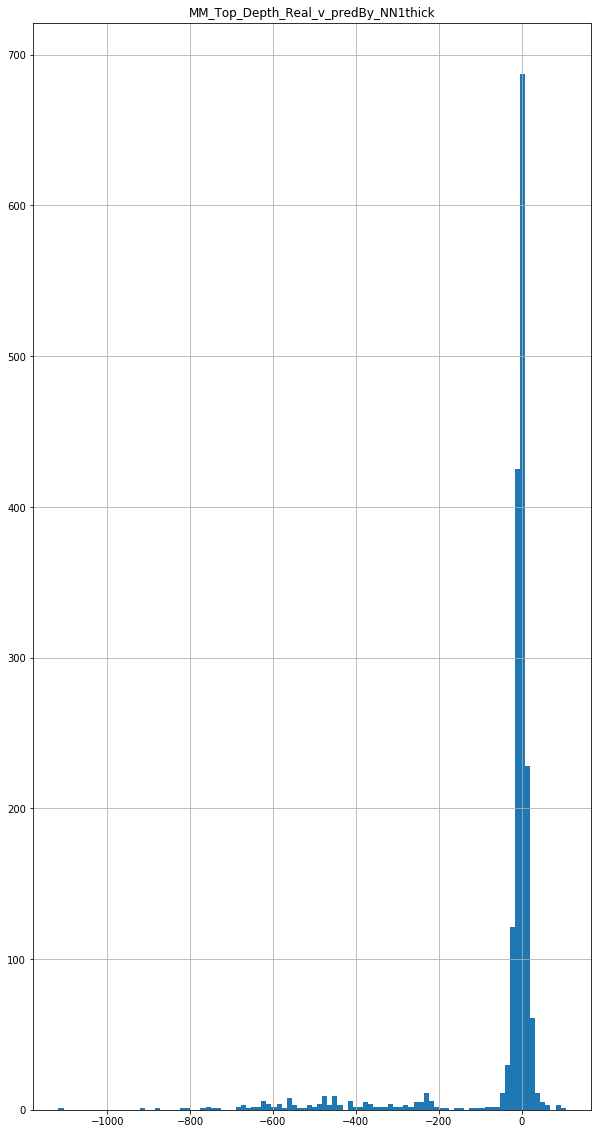

In [283]:
### Positive numbers are where real top is greater than predicted (200 vs. 100)
### Negative numbers are where real top is less than predicted top (0 vs. 500)
### Many negative numbers might be due to :
###    1) zeros & blanks being skipped in nearest neighbors and
###    2) not being skipped in 'real' tops 
doNotSaveThisDF_temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(10,20))

## The really high negative values might be from wells that don't have a base pick ? 0 - thickness in neighboring well where as the high positive numbers might be wells that have a base in neighboring well but not in well being predicting for?

### Let's investigate further by looking at the distribution of the thickness in nieghboring wells

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7c95bd5af940>]],
      dtype=object)

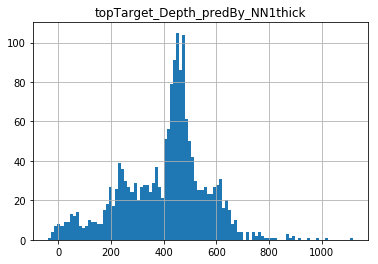

In [286]:
#MM_Top_Depth_Real_v_predBy_NN1thick
# temp5.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100)
doNotSaveThisDF_temp5.hist(column='topTarget_Depth_predBy_NN1thick', bins=100)

- Most are around 430 with a big range that has shoulders around 200 and 600 thickness. 
- There are a few with less than zero? Are thosse were there was a base but not a top or the other way?

#### Let's check to see how many McMurray_Top_DEPTH and McMurray_Base_DEPTH are zeros

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7c95bd27ea90>]],
      dtype=object)

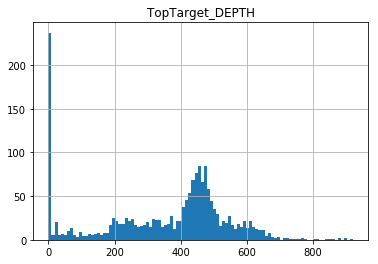

In [288]:
doNotSaveThisDF_temp5.hist(column='TopTarget_DEPTH', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7c95bd16a2e8>]],
      dtype=object)

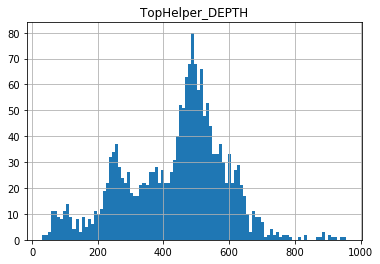

In [289]:
doNotSaveThisDF_temp5.hist(column='TopHelper_DEPTH', bins=100)

### Let's investigate what is causing the problem above and find out where the zeros or missing values are

First, get absolute numbers intead of just a histogram

In [290]:
df_test = doNotSaveThisDF_temp5.copy()

In [291]:
#### number of rows in each column with null values
df_test.isnull().sum()

SitID                                   0
lat                                     0
lng                                     0
UWI                                     0
TopHelper_HorID                         0
TopTarget_HorID                         0
TopHelper_DEPTH                         0
TopTarget_DEPTH                         0
TopHelper_HorID_Qual                    0
TopTarget_Qual                          0
Neighbors_Obj                           0
NN1_topTarget_DEPTH                    73
NN1_TopHelper_DEPTH                     0
NN1_thickness                          73
topTarget_Depth_predBy_NN1thick        73
MM_Top_Depth_Real_v_predBy_NN1thick    73
dtype: int64

In [292]:
#### number of rows in each column with zero values
df_test[df_test.NN1_topTarget_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

#### Looks like both are issue but Top is bigger issue.

In [293]:
df_test[df_test.TopHelper_DEPTH == 0].count()

SitID                                  0
lat                                    0
lng                                    0
UWI                                    0
TopHelper_HorID                        0
TopTarget_HorID                        0
TopHelper_DEPTH                        0
TopTarget_DEPTH                        0
TopHelper_HorID_Qual                   0
TopTarget_Qual                         0
Neighbors_Obj                          0
NN1_topTarget_DEPTH                    0
NN1_TopHelper_DEPTH                    0
NN1_thickness                          0
topTarget_Depth_predBy_NN1thick        0
MM_Top_Depth_Real_v_predBy_NN1thick    0
dtype: int64

### It appears there are 247 base McMurray picks with zero values and this is causing the problems
### Without a base, we can't add the nearest neighbor McMurray thickness to it and git a starting point to look for the top McMurray pick

### Below we will limit the dataset distribution to  only those wells that do have an interpreted McMurray base pick.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a84d90710>]],
      dtype=object)

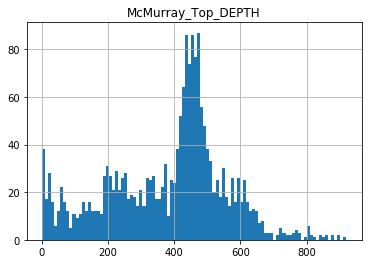

In [73]:
no_zeros_df = df_test[(df_test['McMurray_Base_DEPTH']!=0) & (df_test['McMurray_Top_DEPTH']!=0)]
no_zeros_df.hist(column='McMurray_Top_DEPTH', bins=100)

In [74]:
no_zeros_df['MM_Top_Depth_Real_v_predBy_NN1thick'] =  no_zeros_df['McMurray_Top_DEPTH'] - no_zeros_df['MM_Top_Depth_predBy_NN1thick'] 


/home/jgosses/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x794a84d63a90>]],
      dtype=object)

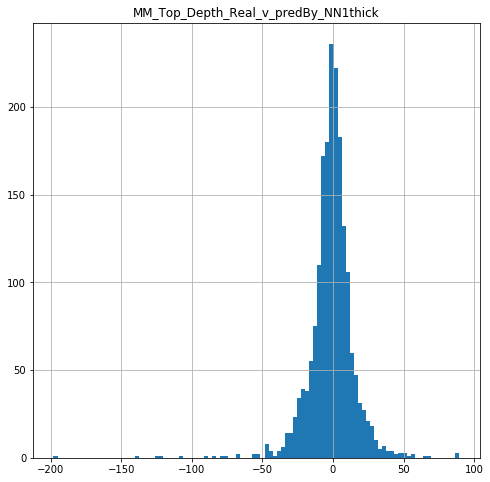

In [75]:
no_zeros_df.hist(column='MM_Top_Depth_Real_v_predBy_NN1thick', bins=100,figsize=(8,8))

In [76]:
len(no_zeros_df)

1926

### The histogram above seems more reasonable

Let's take out the column that might leak information about a wells top McMurray depth and then save this dataframe.

In [77]:
no_zeros_df_TopDepthVsNNleak = no_zeros_df.drop('MM_Top_Depth_Real_v_predBy_NN1thick', 1)

In [78]:
no_zeros_df_TopDepthVsNNleak

,SitID,McMurray_Base_HorID,McMurray_Top_HorID,McMurray_Base_DEPTH,McMurray_Top_DEPTH,McMurray_Base_Qual,McMurray_Top_Qual,lat,lng,UWI,Neighbors_Obj,NN1_McMurray_Top_DEPTH,NN1_McMurray_Base_DEPTH,NN1_thickness,MM_Top_Depth_predBy_NN1thick
0,102496,14000,13000,561.00,475.00,1,3,54.785907,-110.129320,00/12-08-067-01W4/0,"[{'neighbor': 1, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858}, {'neighbor': 3, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222}, {'neighbor': 4, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076}, {'neighbor': 7, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453}]",544.00,630.00,86.00,475.00
1,102497,14000,13000,604.50,515.00,1,3,54.782284,-110.269446,00/07-08-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 3, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727}, {'neighbor': 4, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476}, {'neighbor': 5, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 6, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062}, {'neighbor': 7, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145}]",529.00,613.00,84.00,520.50
2,102498,14000,13000,564.00,480.00,1,3,54.785892,-110.186851,00/09-11-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782}, {'neighbor': 4, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212}, {'neighbor': 5, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036}, {'neighbor': 6, 'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113}, {'neighbor': 7, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725}]",529.00,613.00,84.00,480.00
3,102500,14000,13000,636.50,549.00,1,3,54.829624,-110.269422,00/10-29-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212}, {'neighbor': 2, 'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 3, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529}, {'neighbor': 4, 'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945}, {'neighbor': 5, 'UWI': '00/06-13-068-03W4/0', 'distance': 0.07898840474399109}, {'neighbor': 6, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.08169505420160347}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.08752301126560716}]",529.00,613.00,84.00,552.50
4,102501,14000,13000,613.00,529.00,1,2,54.840471,-110.224832,00/06-34-067-02W4/0,"[{'neighbor': 1, 'UWI': '00/10-29-067-02W4/0', 'distance': 0.04589036401030715}, {'neighbor': 2, 'UWI': '00/09-11-068-02W4/0', 'distance': 0.050134469469623355}, {'neighbor': 3, 'UWI': '00/10-08-068-02W4/0', 'distance': 0.055282561346227096}, {'neighbor': 4, 'UWI': '00/09-11-067-02W4/0', 'distance': 0.06649378619088428}, {'neighbor': 5, 'UWI': '00/07-08-067-02W4/0', 'distance': 0.07332213830078355}, {'neighbor': 6, 'UWI': '00/06-26-068-02W4/0', 'distance': 0.07715524006184091}, {'neighbor': 7, 'UWI': '00/11-29-068-02W4/0', 'distance': 0.09180352126144718}]",514.00,603.00,89.00,524.00
5,102503,14000,13000,553.50,488.50,1,2,54.771449,-110.402983,00/11-04-067-03W4/0,"[{'neighbor': 1, 'UWI': '00/10-08-067-03W4/0', 'distance': 0.023989710460949984}, {'neighbor': 2, 'UWI': '00/10-28-067-03W4/0', 'distance': 0.058530785916471276}, {'neighbor': 3, 'UWI': '00/10-14-067-03W4/0', 'distance': 0.06418817567901171}, {'neighbor': 4, 'UWI': '00/11-24-067-04W4/0', 'distance': 0.08773076140100079}, 

In [79]:
#### dumping wells dataframe that has no zeros in NN depth to pickle file
pickle.dump(no_zeros_df_TopDepthVsNNleak, open( "wells_df__NB_KDtreePost062018_vA__NoMcTopLeak_v2.p", "wb" ) )
# pickle.dump( wells_df_new_cleaned_plus_nn, open( "wells_df_new_cleaned_plus_nn.p", "wb" ) )

### Let's look at the results on a map

In [80]:
import os
import folium
print(folium.__version__)
import branca.colormap as cm
import os
import math
env = %env
pd.set_option('display.max_rows', 2000)

0.5.0


In [81]:
linear2 = cm.LinearColormap(
    ['#edf8b1','#7fcdbb','#2c7fb8','#273891'],
    vmin=-100, vmax=75
)

linear2


# linear3 = cm.LinearColormap(
#     ['darkblue','blue','lightblue','lightgreen','green','darkgreen'],
#      vmax=75,vmin=-100,
# )

# linear3

In [82]:
def depth_color(depth):
    if(math.isnan(depth)):
        print(" math.isnan(depth) => ", depth)
        return 'blue'
    else:
        depth = float(depth)
        if depth >= 50:
            color = '#3182bd'
        elif depth > 10 and depth < 50:
            color = '#9ecae1'
        elif depth > -10 and depth < 10:
            color = 'green'
        elif depth > -50 and depth < -10:
            color = '#ffeda0'
        elif depth > -150 and depth < -50:
            color = '#feb24c'
        elif depth > -300 and depth < -150:
            color = '#f03b20'
        else:
            color = 'blue'
    return color

In [83]:
def depth_color3(depth,colorMap):
    if(math.isnan(depth)):
        print("!!!!!!!!!!!!!!!!!!!!  ' '  or nan is in depth => ", depth)
        color = '#000000'
    else:
        depth = float(depth)
        print("depth in colormap 3",depth)
        color = colorMap(depth)
        
    print("color = ",color)    
    return color

In [84]:
center2 = [54.840471, -110.269399]
zoom2 = 6
m5 = folium.Map(center2, tiles='Stamen Toner', zoom_start=zoom2)

In [85]:


list_df_for_map = no_zeros_df.values.tolist()

for row in list_df_for_map[0:]:
    print("location = ",row[7:9]," and depth is",row[15:16][0], " and UWI is ",row[9:10][0])
    folium.CircleMarker(
    location=row[7:9],
    radius=2,
    color=depth_color(row[15:16][0]),
    fill=True,
#     popup=folium.Popup(str(row[9:10][0])+ " & depth Top McMurray=", parse_html=True)    
#     popup=folium.Popup(str(row[9:10][0]+ ", depth Top McMurray="+str(row[15:16][0])), parse_html=True)
    ).add_to(m5)

location =  [54.785906999999995, -110.12931999999999]  and depth is 0.0  and UWI is  00/12-08-067-01W4/0
location =  [54.782284, -110.269446]  and depth is -5.5  and UWI is  00/07-08-067-02W4/0
location =  [54.785892000000004, -110.186851]  and depth is 0.0  and UWI is  00/09-11-067-02W4/0
location =  [54.829624, -110.26942199999999]  and depth is -3.5  and UWI is  00/10-29-067-02W4/0
location =  [54.840470999999994, -110.224832]  and depth is 5.0  and UWI is  00/06-34-067-02W4/0
location =  [54.771449, -110.402983]  and depth is -0.5  and UWI is  00/11-04-067-03W4/0
location =  [54.785901, -110.42213100000001]  and depth is -6.5  and UWI is  00/10-08-067-03W4/0
location =  [54.800532999999994, -110.34576200000001]  and depth is 11.5  and UWI is  00/10-14-067-03W4/0
location =  [54.829632999999994, -110.396621]  and depth is 6.5  and UWI is  00/10-28-067-03W4/0
location =  [54.840441000000006, -110.320301]  and depth is -25.5  and UWI is  00/07-36-067-03W4/0
location =  [54.771451, -11

location =  [54.873029, -111.851923]  and depth is 3.3600000000000136  and UWI is  00/11-12-068-13W4/0
location =  [54.916755, -111.89666100000001]  and depth is -0.2999999999999545  and UWI is  00/10-27-068-13W4/0
location =  [54.92759, -111.89663700000001]  and depth is 0.910000000000025  and UWI is  00/07-34-068-13W4/0
location =  [54.916751, -112.00455600000001]  and depth is 3.0500000000000114  and UWI is  00/11-25-068-14W4/0
location =  [54.92759399999999, -112.049124]  and depth is -31.69999999999999  and UWI is  00/07-34-068-14W4/0
location =  [54.931203000000004, -112.284175]  and depth is 9.759999999999991  and UWI is  00/11-31-068-15W4/0
location =  [54.858266, -112.309458]  and depth is -120.7000000000001  and UWI is  00/11-01-068-16W4/0
location =  [54.872958999999994, -112.58929199999999]  and depth is -8.229999999999905  and UWI is  00/11-07-068-17W4/0
location =  [54.887595, -112.59553500000001]  and depth is -3.6899999999999977  and UWI is  00/12-18-068-17W4/0
location

location =  [55.043803000000004, -111.87756599999999]  and depth is 6.0  and UWI is  00/06-11-070-13W4/0
location =  [55.072952, -111.909252]  and depth is -7.0  and UWI is  00/05-22-070-13W4/0
location =  [55.087517000000005, -111.877633]  and depth is -6.0  and UWI is  00/06-26-070-13W4/0
location =  [55.102132999999995, -112.125386]  and depth is -6.6200000000000045  and UWI is  00/07-31-070-14W4/0
location =  [55.102141, -112.112443]  and depth is 3.0  and UWI is  00/05-32-070-14W4/0
location =  [55.033105000000006, -112.28421499999999]  and depth is 13.5  and UWI is  00/11-06-070-15W4/0
location =  [55.058615, -112.25256599999999]  and depth is -13.5  and UWI is  00/07-17-070-15W4/0
location =  [55.069453, -112.258853]  and depth is -4.0  and UWI is  00/03-20-070-15W4/0
location =  [55.109595, -112.22083400000001]  and depth is -7.240000000000066  and UWI is  00/16-33-070-15W4/0
location =  [55.043944999999994, -112.41141499999999]  and depth is -39.20999999999998  and UWI is  00/

location =  [55.117230000000006, -113.84310900000001]  and depth is -7.330000000000041  and UWI is  00/06-06-071-25W4/0
location =  [55.150045999999996, -113.83671899999999]  and depth is -3.3600000000001273  and UWI is  00/10-18-071-25W4/0
location =  [55.160885, -113.791758]  and depth is 88.38000000000011  and UWI is  00/06-21-071-25W4/0
location =  [55.179118, -113.73413500000001]  and depth is -19.510000000000105  and UWI is  00/10-26-071-25W4/0
location =  [55.135681999999996, -113.939148]  and depth is 1.2100000000000364  and UWI is  00/10-09-071-26W4/0
location =  [55.150234, -113.91351999999999]  and depth is -1.1399999999999864  and UWI is  00/10-15-071-26W4/0
location =  [55.150346, -113.945485]  and depth is 1.1399999999999864  and UWI is  00/11-16-071-26W4/0
location =  [55.161345999999995, -113.990523]  and depth is -4.259999999999991  and UWI is  00/07-19-071-26W4/0
location =  [55.121506000000004, -114.069445]  and depth is -8.57000000000005  and UWI is  00/11-03-071-01

location =  [55.222729, -112.94555]  and depth is -3.3500000000000227  and UWI is  00/11-12-072-20W4/0
location =  [55.28091800000001, -112.971153]  and depth is -14.519999999999982  and UWI is  00/11-35-072-20W4/0
location =  [55.255430000000004, -113.19555700000001]  and depth is -2.0  and UWI is  00/15-20-072-21W4/0
location =  [55.208231000000005, -113.40068799999999]  and depth is -14.92999999999995  and UWI is  00/10-01-072-23W4/0
location =  [55.219065, -113.407036]  and depth is 7.280000000000086  and UWI is  00/06-12-072-23W4/0
location =  [55.25539200000001, -113.496955]  and depth is -0.6299999999999955  and UWI is  00/16-20-072-23W4/0
location =  [55.280878, -113.477655]  and depth is 1.8000000000000682  and UWI is  00/10-33-072-23W4/0
location =  [55.208211999999996, -113.554585]  and depth is 0.0  and UWI is  00/10-01-072-24W4/0
location =  [55.219079, -113.65712099999999]  and depth is 9.149999999999977  and UWI is  00/07-08-072-24W4/0
location =  [55.262787, -113.682782

location =  [55.353664, -113.67649499999999]  and depth is 4.329999999999927  and UWI is  00/09-30-073-24W4/0
location =  [55.309937, -113.75336999999999]  and depth is -8.5  and UWI is  00/09-10-073-25W4/0
location =  [55.31354, -113.702097]  and depth is -18.5  and UWI is  00/16-12-073-25W4/0
location =  [55.346426, -113.72103100000001]  and depth is 8.68999999999994  and UWI is  00/04-25-073-25W4/0
location =  [55.321037, -113.88156299999999]  and depth is 8.240000000000009  and UWI is  00/08-14-073-26W4/0
location =  [55.368239, -113.89422900000001]  and depth is 27.730000000000018  and UWI is  00/11-35-073-26W4/0
location =  [55.295938, -114.114231]  and depth is 43.940000000000055  and UWI is  00/10-05-073-01W5/0
location =  [55.310387, -114.114225]  and depth is 15.409999999999968  and UWI is  00/10-08-073-01W5/0
location =  [55.32864, -114.056601]  and depth is -4.100000000000023  and UWI is  00/16-15-073-01W5/0
location =  [55.295937, -114.22309299999999]  and depth is 15.0  a

location =  [55.52817099999999, -110.66231499999999]  and depth is -11.5  and UWI is  00/10-26-075-05W4/0
location =  [55.470017000000006, -110.875753]  and depth is 41.0  and UWI is  00/11-04-075-06W4/0
location =  [55.480858, -110.86936200000001]  and depth is 27.5  and UWI is  00/07-09-075-06W4/0
location =  [55.499106000000005, -110.86936200000001]  and depth is -41.0  and UWI is  00/10-16-075-06W4/0
location =  [55.539013, -110.79811299999999]  and depth is 3.0  and UWI is  00/06-36-075-06W4/0
location =  [55.470020999999996, -111.024654]  and depth is -2.750000000000057  and UWI is  00/10-04-075-07W4/0
location =  [55.495475, -110.94700800000001]  and depth is 10.0  and UWI is  00/07-13-075-07W4/0
location =  [55.509944, -110.979281]  and depth is -13.720000000000027  and UWI is  00/06-23-075-07W4/0
location =  [55.542649, -110.998772]  and depth is -5.039999999999964  and UWI is  00/10-34-075-07W4/0
location =  [55.48445600000001, -111.21226499999999]  and depth is -4.1499999999

location =  [55.586346, -111.42559299999999]  and depth is 18.5  and UWI is  00/12-13-076-10W4/0
location =  [55.582738, -111.522724]  and depth is -4.930000000000007  and UWI is  00/06-17-076-10W4/0
location =  [55.626266, -111.40649499999999]  and depth is -9.0  and UWI is  00/08-36-076-10W4/0
location =  [55.58274599999999, -111.67156299999999]  and depth is -4.8799999999999955  and UWI is  00/07-17-076-11W4/0
location =  [55.615448, -111.61981499999999]  and depth is 0.5500000000000114  and UWI is  00/10-27-076-11W4/0
location =  [55.626264, -111.568071]  and depth is 4.8799999999999955  and UWI is  00/07-36-076-11W4/0
location =  [55.568117, -111.826799]  and depth is -0.32999999999992724  and UWI is  00/07-08-076-12W4/0
location =  [55.611837, -111.74918000000001]  and depth is -12.480000000000018  and UWI is  00/07-26-076-12W4/0
location =  [55.626276000000004, -111.85906000000001]  and depth is -12.789999999999907  and UWI is  00/06-31-076-12W4/0
location =  [55.629903000000006

location =  [55.640889, -113.560552]  and depth is 0.5299999999999727  and UWI is  00/07-06-077-23W4/0
location =  [55.688042, -113.45702]  and depth is 6.389999999999986  and UWI is  00/10-23-077-23W4/0
location =  [55.702684999999995, -113.489299]  and depth is -36.289999999999964  and UWI is  00/11-27-077-23W4/0
location =  [55.644503, -113.592831]  and depth is 25.600000000000136  and UWI is  00/11-01-077-24W4/0
location =  [55.699059, -113.58643799999999]  and depth is -44.190000000000055  and UWI is  00/07-25-077-24W4/0
location =  [55.702693000000004, -113.689968]  and depth is -7.680000000000064  and UWI is  00/10-29-077-24W4/0
location =  [55.71715, -113.638203]  and depth is 33.889999999999986  and UWI is  00/10-34-077-24W4/0
location =  [55.669986, -113.851623]  and depth is 5.17999999999995  and UWI is  00/06-17-077-25W4/0
location =  [55.68444100000001, -113.773996]  and depth is -13.620000000000005  and UWI is  AA/06-23-077-25W4/0
location =  [55.702674, -113.877496999999

location =  [55.782743, -113.57325700000001]  and depth is 4.5  and UWI is  00/04-30-078-23W4/0
location =  [55.804375, -113.48290800000001]  and depth is -13.099999999999966  and UWI is  00/10-34-078-23W4/0
location =  [55.757256000000005, -113.62502099999999]  and depth is -10.0  and UWI is  AA/05-14-078-24W4/0
location =  [55.775303, -113.71583600000001]  and depth is 1.5199999999999818  and UWI is  00/10-19-078-24W4/0
location =  [55.775319999999994, -113.68996000000001]  and depth is -1.2200000000000273  and UWI is  00/10-20-078-24W4/0
location =  [55.728148, -113.87749699999999]  and depth is -30.470000000000027  and UWI is  AA/06-06-078-25W4/0
location =  [55.77530600000001, -113.87110700000001]  and depth is -15.009999999999991  and UWI is  00/10-19-078-25W4/0
location =  [55.78631899999999, -113.748099]  and depth is -1.5199999999999818  and UWI is  00/06-25-078-25W4/0
location =  [55.800793999999996, -113.79985500000001]  and depth is 24.099999999999966  and UWI is  00/06-34-

location =  [55.869877, -113.50656000000001]  and depth is -6.229999999999961  and UWI is  00/01-27-079-23W4/0
location =  [55.815324, -113.61742199999999]  and depth is 5.5  and UWI is  00/07-01-079-24W4/0
location =  [55.818934, -113.747925]  and depth is -26.0  and UWI is  00/10-06-079-24W4/0
location =  [55.844409, -113.695714]  and depth is 13.109999999999957  and UWI is  00/07-16-079-24W4/0
location =  [55.818968000000005, -113.85233799999999]  and depth is -10.990000000000009  and UWI is  00/10-04-079-25W4/0
location =  [55.833403000000004, -113.78048000000001]  and depth is -0.5  and UWI is  00/11-12-079-25W4/0
location =  [55.858879, -113.80658400000002]  and depth is 22.5  and UWI is  00/06-23-079-25W4/0
location =  [55.88796899999999, -113.852322]  and depth is -0.9599999999999795  and UWI is  AA/07-33-079-25W4/0
location =  [55.87368000000001, -113.956702]  and depth is -8.54000000000002  and UWI is  00/07-26-079-26W4/0
location =  [55.81940600000001, -114.011729]  and dept

location =  [56.051680000000005, -112.15570100000001]  and depth is 1.5  and UWI is  AA/10-29-081-14W4/0
location =  [56.066128000000006, -112.234008]  and depth is -4.0  and UWI is  00/10-35-081-15W4/0
location =  [55.993506000000004, -112.416723]  and depth is -5.5  and UWI is  00/10-03-081-16W4/0
location =  [56.051669999999994, -112.390571]  and depth is -79.88  and UWI is  00/10-26-081-16W4/0
location =  [56.004325, -112.625532]  and depth is -2.530000000000001  and UWI is  00/07-08-081-17W4/0
location =  [56.022564, -112.547273]  and depth is 33.43999999999994  and UWI is  00/10-14-081-17W4/0
location =  [56.051639, -112.52765]  and depth is 1.2200000000000841  and UWI is  00/11-25-081-17W4/0
location =  [56.004332999999995, -112.782154]  and depth is -5.7900000000000205  and UWI is  00/07-08-081-18W4/0
location =  [56.007939, -112.684206]  and depth is 57.349999999999966  and UWI is  00/11-12-081-18W4/0
location =  [56.022579, -112.886559]  and depth is 7.239999999999952  and UW

location =  [56.124313, -111.97299]  and depth is 2.5  and UWI is  00/10-21-082-13W4/0
location =  [56.138940000000005, -111.999098]  and depth is -4.840000000000032  and UWI is  00/10-29-082-13W4/0
location =  [56.080757, -112.181804]  and depth is 2.0  and UWI is  00/10-06-082-14W4/0
location =  [56.10985600000001, -112.129601]  and depth is -6.0  and UWI is  00/10-16-082-14W4/0
location =  [56.135328, -112.109945]  and depth is 3.3700000000000045  and UWI is  00/06-27-082-14W4/0
location =  [56.09521899999999, -112.312257]  and depth is -0.5  and UWI is  00/10-08-082-15W4/0
location =  [56.135313000000004, -112.214352]  and depth is 4.0  and UWI is  00/06-25-082-15W4/0
location =  [56.149749, -112.47538]  and depth is -2.4399999999999977  and UWI is  00/06-32-082-16W4/0
location =  [56.149768, -112.42309099999999]  and depth is 0.6099999999999568  and UWI is  00/06-34-082-16W4/0
location =  [56.149765, -112.370801]  and depth is -6.399999999999977  and UWI is  00/06-36-082-16W4/0
lo

location =  [56.328062, -110.67416000000001]  and depth is -84.0  and UWI is  00/10-35-084-05W4/0
location =  [56.251822, -110.917774]  and depth is 7.0  and UWI is  00/06-05-084-06W4/0
location =  [56.298961, -110.81241399999999]  and depth is 16.5  and UWI is  00/11-24-084-06W4/0
location =  [56.313614, -110.91128799999998]  and depth is 68.30000000000001  and UWI is  00/10-29-084-06W4/0
location =  [56.328065, -110.91779199999999]  and depth is -24.80000000000001  and UWI is  AB/11-32-084-06W4/0
location =  [56.284543000000006, -111.023154]  and depth is -32.89999999999998  and UWI is  AA/11-15-084-07W4/0
location =  [56.284539, -111.075837]  and depth is 17.399999999999977  and UWI is  AA/11-17-084-07W4/0
location =  [56.313628, -111.06282900000001]  and depth is -6.639999999999986  and UWI is  AA/09-29-084-07W4/0
location =  [56.269901000000004, -111.260172]  and depth is -4.689999999999998  and UWI is  AA/11-07-084-08W4/0
location =  [56.269911, -111.240261]  and depth is 3.36000

location =  [56.462688, -112.623011]  and depth is 10.280000000000001  and UWI is  AA/15-16-086-17W4/0
location =  [56.48455500000001, -112.55065800000001]  and depth is -0.3900000000000148  and UWI is  AA/06-25-086-17W4/0
location =  [56.477097, -112.741243]  and depth is nan  and UWI is  00/13-23-086-18W4/0
 math.isnan(depth) =>  nan
location =  [56.48449300000001, -113.28148200000001]  and depth is 0.3100000000000023  and UWI is  00/07-29-086-21W4/0
location =  [56.426339, -113.433024]  and depth is -9.460000000000036  and UWI is  00/08-05-086-22W4/0
location =  [56.444402000000004, -113.439526]  and depth is -9.140000000000043  and UWI is  00/10-08-086-22W4/0
location =  [56.502545, -113.446027]  and depth is 9.140000000000043  and UWI is  00/11-32-086-22W4/0
location =  [56.498932999999994, -113.334167]  and depth is 9.75  and UWI is  00/07-36-086-22W4/0
location =  [56.444413, -113.51854399999999]  and depth is 3.3500000000000227  and UWI is  00/10-11-086-23W4/0
location =  [56.4

location =  [56.760698, -111.37099599999999]  and depth is 24.37999999999998  and UWI is  AA/07-33-089-09W4/0
location =  [56.76430500000001, -111.317854]  and depth is -25.909999999999997  and UWI is  AA/10-35-089-09W4/0
location =  [56.720738, -111.490559]  and depth is -13.849999999999994  and UWI is  AA/12-14-089-10W4/0
location =  [56.731573, -111.563675]  and depth is -9.0  and UWI is  AA/06-20-089-10W4/0
location =  [56.760678000000006, -111.48398799999998]  and depth is 35.5  and UWI is  AA/06-35-089-10W4/0
location =  [56.684449, -111.723184]  and depth is -11.27000000000001  and UWI is  AA/03-05-089-11W4/0
location =  [56.706117000000006, -111.7432]  and depth is -2.4399999999999977  and UWI is  AA/10-07-089-11W4/0
location =  [56.684442000000004, -111.796369]  and depth is 4.260000000000019  and UWI is  AA/02-02-089-12W4/0
location =  [56.717121, -111.9027]  and depth is 6.579999999999984  and UWI is  AA/07-18-089-12W4/0
location =  [56.749829000000005, -111.882671]  and dep

location =  [56.946364, -111.558226]  and depth is -8.659999999999997  and UWI is  AA/04-04-092-10W4/0
location =  [56.968038, -111.55154499999999]  and depth is -0.1599999999999966  and UWI is  AA/11-09-092-10W4/0
location =  [56.97545, -111.524732]  and depth is 8.66  and UWI is  AA/03-15-092-10W4/0
location =  [57.029842, -111.518125]  and depth is 11.840000000000003  and UWI is  AB/15-34-092-10W4/0
location =  [56.94641800000001, -111.745869]  and depth is 2.1400000000000006  and UWI is  AA/04-05-092-11W4/0
location =  [56.997122999999995, -111.766152]  and depth is 6.400000000000006  and UWI is  AA/11-19-092-11W4/0
location =  [56.989915, -111.665411]  and depth is 1.0  and UWI is  AB/04-23-092-11W4/0
location =  [57.00458100000001, -111.75290600000001]  and depth is 5.180000000000007  and UWI is  AA/01-30-092-11W4/0
location =  [56.946422, -111.887078]  and depth is -9.5  and UWI is  AA/01-05-092-12W4/0
location =  [56.975497999999995, -111.906879]  and depth is -4.0  and UWI is 

location =  [57.200697999999996, -112.46396499999999]  and depth is -4.0  and UWI is  00/11-35-094-16W4/0
location =  [57.197077, -112.437124]  and depth is -2.769999999999982  and UWI is  03/06-36-094-16W4/0
location =  [57.193451, -112.732386]  and depth is 13.5  and UWI is  00/03-31-094-17W4/0
location =  [57.167984, -112.765786]  and depth is 1.0  and UWI is  00/05-24-094-18W4/0
location =  [57.215472999999996, -110.856482]  and depth is -21.5  and UWI is  AA/10-02-095-06W4/0
location =  [57.229921999999995, -110.856481]  and depth is -18.0  and UWI is  AA/10-11-095-06W4/0
location =  [57.20821, -110.98517199999999]  and depth is -27.0  and UWI is  AA/01-01-095-07W4/0
location =  [57.237367000000006, -111.025622]  and depth is 6.5  and UWI is  00/03-14-095-07W4/0
location =  [57.258993999999994, -111.10686000000001]  and depth is -35.5  and UWI is  AA/11-20-095-07W4/0
location =  [57.280846999999994, -111.012245]  and depth is -2.0  and UWI is  AA/01-35-095-07W4/0
location =  [57.2

location =  [57.4481, -111.127246]  and depth is -23.0  and UWI is  AA/10-30-097-07W4/0
location =  [57.462561, -111.100167]  and depth is 32.0  and UWI is  AA/10-32-097-07W4/0
location =  [57.382728, -111.248855]  and depth is -22.5  and UWI is  AA/04-04-097-08W4/0
location =  [57.407998, -111.154326]  and depth is -14.5  and UWI is  AA/15-12-097-08W4/0
location =  [57.437079000000004, -111.154327]  and depth is 15.320000000000002  and UWI is  AA/15-24-097-08W4/0
location =  [57.40799499999999, -111.45885600000001]  and depth is 10.0  and UWI is  AA/14-07-097-09W4/0
location =  [57.4154, -111.458868]  and depth is -21.0  and UWI is  AA/06-18-097-09W4/0
location =  [57.444480000000006, -111.45891499999999]  and depth is 35.0  and UWI is  AA/06-30-097-09W4/0
location =  [57.389922, -111.628091]  and depth is 24.0  and UWI is  AA/12-06-097-10W4/0
location =  [57.411793, -111.60805500000001]  and depth is -15.5  and UWI is  AA/01-18-097-10W4/0
location =  [57.444492000000004, -111.5196790

In [86]:
m5

### In general it seems the variance is relatively evenly distributed. 
A lot of the map has green, which means the neighboring wells thickness + base results in a top prediction that is within plus or minues 10 feet. Where the difference is outside that range, it seems it isn't that much farther off most of the time. There might be some areas in NE and eastern margin where variance is larger than in central area.

In [87]:
m5.save(os.path.join('.', 'MM_Top_Depth_Real_v_predBy_NN1thick_v2.html'))

#### might try this d3.js block of leaflet.js for ideas on how to draw polygons over the map and then use those polygons as features.

https://bl.ocks.org/danswick/d30c44b081be31aea483

### Future work

In [83]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    
    
    return uwi_array, distance_array
    

In [84]:
#### 1. Find average pick depth of N neighbor wells within a certain maximum distance
#### takes in array or pandas df? returns dataframe?
def avgPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return uwi_nearest, uwi_array, nearest_TopM_depth, avg_TopM_depth, nearest_BaseM_depth, avg_BaseM_depth
    

In [85]:
#### 2. Return an array of pick depths at N neighbor wells within a certain maximum distance.
#### takes in array or pandas df? returns dataframe?
def arrayOfPickDepthForKneighborsWcertainDist(array,k_neighbors,max_distance):
    return array_of_depths
    

In [86]:
#### 3. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def avgDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return avg_of_depthsAbvBelow

In [87]:
#### 4. Return the average depth above or below another known pickin N nearest neighbor wells
#### takes in array or pandas df? returns dataframe?
def arrayDepthAbvOrBelowKneighborsWcertainDist(array,k_neighbors,max_distance,aboveOrbelow,pickA,pickB):
    return array_of_depthsAbvBelow

# Next step is to bring in the dataframe with the well data that has been split into train and test portions. 
# We will:
## 1. Merge it with the location, picks, and nearest neighbors data.
## 2. Get a list of the wells that are in the test dataset and re-run the nearest neighbors process using only the wells in the training dataset!
## 3. We'll then over-write the neighbor thickness feature columns but only for the rows that correspond to the training wells, not the test wells.